# Explication du projet

La société Prêt à Dépenser est une société financière  qui propose des crédits à la consommation. Dans une logique de gestion du risque, l’entreprise souhaite mettre en place un outil de scoring de crédits capable d’estimer la probabilité qu’un client rembourse son emprunt. Cet outil permettra de classer automatiquement les demandes en deux catégories : les demandes de prêts peu risquées qui seront acceptées ou les demandes de prêts risquées qui seront refusées. Pour déveloper ce modèle de classification, la société a fourni un large pannel de données provenant de différentes sources et inclus des informations sociodémographiques et des données issues d'autres institutions financières.

Dans le notebook précédent, les différentes tables de données fournies par la société Place de marchés ont été explorées de manière à comprendre les données, a évaluer leur qualité et à identifier les variables pertinentes pour l'objectif du projet. Suite à cela, la table correspondant aux demandes de prêts a été enrichie via une jointure des variables identifiées précedemment et de nouvelles variables construites pour apporter des informations supplémentaires. La qualité de cette table enrichie a été évaluée puis a été analysée, pour identifier des premières tendances de relations entres les variables explicatives et entre les variables explicative et la variable cible. Dans le présent notebook, différents modèles de classification seront dans un premier temps explorés, évalués et optimisés. Puis, le modèle finale retenu sera analysé plus en profondeur pour identifier les variables qui auront le plus implacté les résultats de prédiction du modèle.

# Sommaire
- [1 Explication du projet](#Explication-du-projet)
- [2 Sommaire](#Sommaire)
- [3 Import](#Import-des-bibliothèques-et-des-données)
- [4 Prétraitement des données](#Prétraitement-des-données-pour-la-modélisation)
- [5 Modélisation: Approche exploratoire](#Modélisation:-approche-exploiratoire)
- [6 Modélisation: Optimisation](#Modélisation:-optimisation)
- [7 Explicativité du modèle retenu](#Explicativité-du-modèle-retenu)
- [8 Sauvegarde du modèle pour le déploiement](#Sauvegarde-du-modèle-pour-le-déploiement)
- [9 Conclusions](#Conclusions)


# Import des bibliothèques et des données

**Librairies**

In [1]:
# Librairies utiles
import logging
import math
import os
import time
import warnings
from datetime import datetime
import joblib
import sys
from tensorflow.keras.utils import Progbar

# Manipulation et analyse de données
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_object_dtype, CategoricalDtype

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame, Image, display
from plotnine import *
from tqdm import tqdm

# Scikit-learn et imblearn - Pipeline, préprocessing, modèles, métriques
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    confusion_matrix,
    fbeta_score,
    get_scorer,
    make_scorer,
    precision_recall_curve, 
    recall_score)

from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Modèles externes
import lightgbm as lgb

# Optimisation d'hyperparamètres
import optuna
from optuna.importance import get_param_importances
from optuna.logging import WARNING, set_verbosity
from optuna.visualization import plot_slice

# Suivi d'expérimentations
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Explainers et interprétabilité
import shap


**Données**

In [2]:
# Exctraction de la date pour nommer certaines sauvegardes en fonction de la date
date_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [3]:
# Chargement de la table de données d'entrainement
App_train_enrichi = pd.read_csv("../Output/Data_clients/App_train_final.csv")

# Chargement de la table de données de test
App_test_enrichi = pd.read_csv("../Output/Data_clients/App_test_final.csv")

# Prétraitement des données pour la modélisation

Le jeu de données chargé contient la variable cible, qu'il faudra isoler dès les premières étapes de traitement afin de ne pas l'inclure dans les étapes de prétraitement et de modélisation. Avant de passer à cette phase de modélisation, plusieurs étapes de prétraitement seront donc appliquées aux données. Ces transformations seront adaptées au type et à la nature de chaque variable. Pour cela, cinq listes distinctes de variables seont définies, chacune correspondant à un traitement spécifique :

- **num_cols_c_actifs** regroupant les variables numériques liés aux crédits actifs. Celles ci feront l’objet d’une imputation des valeurs manquantes par la médiane lorsque le nombre de crédits actifs d'un client est > 0 ou par -1 sinon, puis seront standardisées afin de garantir une échelle comparable entre les différentes caractéristiques.
- **num_cols_c_approuved** regroupant les variables numériques liés aux crédits accordés. Celles ci feront l’objet d’une imputation des valeurs manquantes par la médiane lorsque le nombre de crédits accordés est > 0 ou par -1 sinon, puis seront standardisées afin de garantir une échelle comparable entre les différentes caractéristiques.
- **num_other_cols** regroupant les autres variables numériques. Celles ci feront l’objet d’une imputation des valeurs manquantes par la médiane, puis seront standardisées afin de garantir une échelle comparable entre les différentes caractéristiques.
- **cat_cols_label** regroupant les variables catégorielles binaires qui seront encodées via un OrdinalEncoder, chaque modalité étant transformée par 0 ou 1.
- **cat_cols_OneHot** regroupant les variables catégorielles avec plus de deux modalités. Celles ci seront transformées à l’aide d’un OneHotEncoder, qui permet de créer une nouvelle colonne pour chaque modalité, permettant ainsi une représentation non ordonnée et évitant toute interprétation erronée de l’ordre des catégories par les modèles.

Ces étapes de prétraitement permettront d’obtenir des données prêtes à être utilisées pour la phase de modélisation, tout en respectant la nature des variables. Ces étapes seront intégrées dans une pipeline afin d’assurer la reproductibilité et la cohérence entre l’entraînement et l’inférence, ainsi que la réduction des risques de fuite de données. Cette pipeline facilitera également le déploiement du modèle en encapsulant l’ensemble des transformations et du processus de prédiction dans un processus clairement structuré.

In [4]:
# Ajout du dossier parent dans les chemins d'import
sys.path.append(os.path.abspath(".."))

# Import d'une classe home made qui sera utilisée pour le prétraitement des variables liées au crédits actifs et approuvés
from Utils.Conditional_imputer import ConditionalImputer

# Définition des variables à garder
features = [feat for feat in App_train_enrichi.columns if feat != 'TARGET' and feat!='SK_ID_CURR']

# Séparation des données et de la cible
X_train = App_train_enrichi[features]
Y_train = App_train_enrichi['TARGET']

# Définition des variables liées aux crédits approuvés
num_cols_c_approuved = ['nb_credit_approuves', 'montant_mensuel_min', 
                       'montant_total', 'montant_mensuel_mean',
                       'n_jours_credit_mean', 'n_jours_credit_min', 'n_jours_credit_max',
                       'n_jours_retard_moyen', 'ratio_echeance_retard', 'ratio_approuve_demande']

# Définition des variables liées aux crédits actifs
num_cols_c_actifs = ['n_contrat_actif', 'montant_mensuel_actif', 'montant_dette_restante',
                     'n_jours_restant_mean', 'n_jours_restant_min', 'n_jours_restant_max']

# Définition des autres listes de variables
num_other_cols = [c for c in X_train.columns if is_numeric_dtype(X_train[c]) 
                  and c not in (num_cols_c_approuved + num_cols_c_actifs)]
cat_cols_label = [c for c in X_train.select_dtypes(include='object').columns if X_train[c].nunique() <= 2]
cat_cols_OneHot = [c for c in X_train.select_dtypes(include='object').columns if X_train[c].nunique() > 2]

# Défintion des pipelines associées aux variables numériques
num_var_approuve = Pipeline([
    ('conditional_imputer', ConditionalImputer(ref_col='nb_credit_approuves', variables=num_cols_c_approuved)),
    ('scaler', StandardScaler())
])
num_var_actif = Pipeline([
    ('conditional_imputer', ConditionalImputer(ref_col='n_contrat_actif', variables=num_cols_c_actifs)),
    ('scaler', StandardScaler())
])
num_other_var = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Définition du préprocesseur complet
preprocessor = ColumnTransformer([
    ('num_var_c_approuve', num_var_approuve, num_cols_c_approuved),
    ('num_var_c_actifs', num_var_actif, num_cols_c_actifs),
    ('num_other', num_other_var, num_other_cols),
    ('cat_cols_label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols_label),
    ('cat_cols_OneHot', OneHotEncoder(handle_unknown='ignore'), cat_cols_OneHot)
])

# Affichage du nombre d'observations et de variables des données d'entrainement
X_train.shape

(246006, 86)

In [5]:
# Séparation des données et de la cible
X_test = App_test_enrichi[features]
Y_test = App_test_enrichi['TARGET']

# Affichage du nombre d'observations et de variables des données de test
X_test.shape

(61501, 86)

# Modélisation: approche exploiratoire

**Objectifs**

L’objectif principal de la modélisation est de prédire le risque de défaut de remboursement d’un client sur un crédit. Autrement dit, il s'agit de calculer la probabilité qu’un client ne respecte pas ses engagements financiers en ne remboursant pas son crédit dans les délais convenus. Pour atteindre cet objectif, plusieurs modèles de classifications supervisés seront explorés. Le résultat sera une prédiction binaire (risque élevé de défaut de paiment / risque faible de défaut de paiment) ou une estimation de la probabilité du risque de défaut, qui pourra être utilisée par les établissements financiers pour prendre des décisions éclairées lors d'une décision pour accorder de nouveaux crédits.

**Bonne pratique**

Une bonne pratique est d'utiliser une pipeline qui permet d’enchaîner plusieurs étapes de traitement et de modélisation. Cette pipeline sera ajustée (fit) uniquement sur les données d’entraînement, puis appliquée (pour appliquer les transformations et les prédictions) sur les données de validation et de test, afin de garantir une évaluation fiable tout en évitant les fuites d’information. 

**Stratégie de gestion du déséquilibre des classes**

L’analyse exploratoire réalisée dans le précédent notebook a révélé que la variable cible à prédire présente une distribution fortement déséquilibrée, avec seulement 8 % de défauts de remboursement contre 92 % de remboursements. Dans ce contexte, il sera important de mettre en place des stratégies visant à gérer ce déséquilibre, afin d’éviter que le modèle ne soit biaisé en faveur de la classe majoritaire. L'une d'entre elle à déjà été appliqué au moment de la séparation des données en jeu d'entrainement et de test via l'utilisation de la méthode de stratification. On peut également avant la phase de modélisation utiliser pendant l'entrainement une technique de rééchantillonnage comme le suréchantillonnage de la classe minoritaire qu'on peut effectuer avec la méthode SMOTE.

**Mesure de performances**

Pour évaluer un modèle de classification, plusieurs métriques sont utiles, notamment la matrice de confusion et le rapport de classification, qui fournissent des informations détaillées sur les prédictions correctes (vrais positifs/négatifs) et les erreurs (faux positifs/négatifs). Dans ce projet, l’enjeu est de limiter le risque de prêter à des mauvais payeurs. Ainsi, les faux négatifs (mauvais payeurs non détectés) sont plus coûteux que les faux positifs. La métrique prioritaire sera donc le rappel (sensibilité), qui mesure la capacité à identifier correctement les mauvais payeurs, réduisant ainsi les prêts risqués. La précision souvent utilisé en classification, qui mesure la proportion de mauvais payeurs correctement détectés parmi les prédictions positives, n’est pas l’objectif principal ici et ne sera donc pas utilisé. La courbe précision-rappel permet d’explorer le compromis entre précision et rappel selon différents seuils de décision. Un autre score combinant précision et rappel correspond au score F2 qui fournit un indicateur qui favorise égakement la détection des mauvais payeurs en pénalisant moins les faux positifs que les faux négatifs.

**Construction d'un score métier plus adapté**

Il pourrait également être intéressant de construire un score métier qui soit plus adapté aux enjeu du projet et qui permettrait d'accorder plus de poids aux faux négatifs que la société veut éviter en priorité qu'au faux positifs qui apparaissent moins problématique. Pour mettre en place ce score, on peut partir du principe qu'un prêt de 10 000 dollars à un client génère 1 000 dollars de bénéfice pour l'agence via les intérêts. On peut alors estimer les gains et pertes associés à chaque type de prédictions:

- Un mauvais payeur prédit comme mauvais payeur (True Positif - TP) rapportera 10 000 dollars à l'agence car elle évite un prêt de 10 000 non remboursé
- Un mauvais payeur prédit comme bon payeur (False Negatif - FN) coutera 10 000 dollars à l'agence car elle accordera un prêt de 10 000 dollars qui ne sera pas remboursé
- Un bon payeur prédit comme bon payeur (True Negatif) rapportera 1 000 dollars car l'agence touchera les 1 000 dollars de bénéfice.
- Un bon payeur prédit comme mauvais payeur (False Positif) coutera 1 000 car l'agence perdra les 1 000 de bénéfice qu'elle aurait pu toucher en accordant le crédit au client.

Sur cette base, on peut proposer un score global de gain métier : S = 10 TP - 10 FN + TN - FP

Ce score permet de mieux refléter les enjeux économiques liés aux décisions de prêt et peut être utilisé pour évaluer la performance de l'outil en développement.

## Fonction d'évaluation de la modélisation

Dans cette première phase d'exporation des modèles, quatre fonctions seront définies pour évaluer les performances des modèles. 

- La première fonction permettra de construire le score métier 
- La deuxième fonction permettra d’évaluer les performances des modèles via une validation croisée, en calculant quatre métriques : la précision moyenne, le score F2, le rappel et le score métier. Ces scores seront calculés sur les données d’entraînement, de validation et de test.
- La troisième fonction permettra de visualiser la matrice de confusion ainsi que la courbe précision-rappel, afin d’analyser plus finement les résultats du modèle sur les données de test.
- La quatrième fonction permettra de comparer les scores des différents modèles à la fois lors de la première phase d'exploration mais aussi suite aux phases d'optimisation qui s'en suivront.

In [6]:
def score_metier(y_true, y_pred):
    
    """
    Calcule un score personnalisé basé sur une matrice de confusion, 
    en attribuant des poids spécifiques aux vrais positifs, vrais négatifs,
    faux positifs et faux négatifs.

    Formule : score = (10 * TP + 1 * TN - 10 * FN - 1 * FP) / N

    Paramètres
        y_true (array-like): Les catégories réelles (valeurs cibles).
        y_pred (array-like): Les catégories prédites (prédictions binaires du modèle).

    Sortie
        Le score normalisé par le nombre total d'observations.
        Un score plus élevé indique de meilleures performances selon la pondération définie.

    """
    
    # Calcul du nombre de faux positifs, faux négatifs, vrais positifs et vrais négatifs
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calcul du score métier
    score = 10 * tp + tn - 10 * fn - 1 * fp
    
    # Normalisation du score
    score = score / len(y_true)
    
    return score


In [7]:
def pipeline_evaluation(pipeline, X_train, y_train, scoring,
                        X_test, y_test, cv_splits=5, random_state=42):
    
    """
    Entraîne et évalue un pipeline sur des données d'entraînement avec validation croisée,
    puis évalue ses performances sur un jeu de test. 

    La fonction calcule plusieurs scores de performance (train, validation CV et test), 
    affiche des boxplots des scores de validation croisée, et retourne un tableau synthétique des résultats
    ainsi que les prédictions de probabilités et classes sur le jeu test.

    Paramètres:
        pipeline (lmblearn.pipeline) : pipeline contenant un estimateur final avec méthodes fit, predict et predict_proba.
        X_train (array-like) : données d'entraînement.
        y_train (array-like) : labels d'entraînement.
        scoring (dict) : dictionnaire contenant le nom des scores
        X_test (array-like) : données de test.
        y_test (array-like) : labels du test. 
        cv_splits (int, optionnel) : nombre de folds pour la validation croisée stratifiée (défaut=5).
        random_state (int, optionnel) : graine pour la reproductibilité (défaut=42).

    Sortie:
        results_df (pd.DataFrame) : Dataframe résumant les scores train, validation (moyenne et std) et test par métrique.
        y_test_pred_probas (np.array) : probabilités prédites sur X_test.
        y_test_pred_classe (np.array) : classes prédites sur X_test.

        
    """
    
    # Nom du modèle
    model_name = pipeline.named_steps['model'].__class__.__name__
    
    # Définition de la stratégie de découpage
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    
    # Application d'une cross validation sur une liste de score
    cv_results = cross_validate(pipeline, X_train, y_train,
                                scoring=scoring, cv=cv,
                                return_train_score=True, n_jobs=-1)

    # Entrainement de la pipeline
    pipeline.fit(X_train, y_train)
    
    # Prédiction des probas et des classes
    y_test_pred_probas = pipeline.predict_proba(X_test)[:, 1]
    y_test_pred_classe = pipeline.predict(X_test)

    # Initialisation de la liste de résultats
    results = []
    
    # Extraction des noms des scores
    score_names = list(scoring.keys())

    # Pour chaque score
    for score_name, scorer in scoring.items():
        
        # Noms des scores générés par cross_validate dans cv_result
        train_key = f'train_{score_name}'
        val_key = f'test_{score_name}'   

        # Obtention des prédictions des classes ou des probabilité sur les données tests
        if score_name in PROBA_SCORES:
            y_test_pred = y_test_pred_probas
        else:
            y_test_pred = y_test_pred_classe

        # Si le scorer est une string, conversion en scorer
        if isinstance(scorer, str):
            scorer_obj = get_scorer(scorer)
            test_score = scorer_obj._score_func(y_test, y_test_pred)
        else:
            # sinon (déjà un make_scorer)
            kwargs = getattr(scorer, "_kwargs", {})
            test_score = scorer._score_func(y_test, y_test_pred, **kwargs)

        
        # Ajout des résultats dans la liste
        results.append({
            "model": model_name,
            "score": score_name,
            "train_score": round(np.mean(cv_results[train_key]), 2),
            "val_score mean": round(np.mean(cv_results[val_key]), 2),
            "val_score std": round(np.std(cv_results[val_key]), 2),
            "test_score": round(test_score, 2)})
        
    # Création d'une dataframe en format long pour seaborn boxplot
    data_for_plot = []
    for metric in scoring:
        val_scores = cv_results[f'test_{metric}']
        for score in val_scores:
            data_for_plot.append({'metric': metric, 'score': score})
    df_val = pd.DataFrame(data_for_plot)

    # Calcul du nombre de scores demandés
    n_metrics = len(scoring)
    
    # Construction des graphiques
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 5), sharey=False)
    
    # Gestion du cas où une seule métric est demandée
    if n_metrics == 1:
        axes = [axes]

    # Pour chaque score, on construit un boxplot
    for ax, metric in zip(axes, scoring):
        sns.boxplot(data=df_val[df_val['metric'] == metric], x='metric', y='score', ax=ax)
        ax.set_title(f"Validation - {metric}", fontsize=18)
        ax.set_xlabel('')
        ax.set_ylabel('Score', fontsize=16)
        ax.tick_params(axis='both', labelsize=16)

    # Ajustement de la figure
    plt.tight_layout()
    
    # Sauvegarde de la figure
    plt.savefig(f'../Output/Performances/Score_validation_croisée_{model_name}.png', format='png')
     
    # Affichage de la figure
    plt.show()

    return pd.DataFrame(results), y_test_pred_probas, y_test_pred_classe


In [8]:
def plot_confmat_and_pr_curve(y_true, y_pred_classes, y_pred_probs, class_names, model_name):
    
    """
    Affiche côte à côte la matrice de confusion et la courbe precision-recall (PR Curve)
    pour évaluer les performances d'un modèle de classification binaire.

    La matrice de confusion est affichée sous forme de heatmap avec Seaborn.
    La courbe Precision-Recall est tracée à partir des probabilités prédites,
    avec l'affichage de l'Average Precision (AP).

    Paramètres
        y_true (array-like): Étiquettes réelles.
        y_pred_classes (array-like): Classes prédites par le modèle.
        y_pred_probs (array-like): Probabilités prédites pour la classe positive.
        class_names (list of str, optionnel): Noms des classes à afficher sur les axes de la matrice de confusion
        model_name (str): Nom du modèle utilisé

    """
    
    # Construction de la matrice de confusion
    conf_mat = confusion_matrix(y_true, y_pred_classes)
    
    # Conversion de la matrice en dataframe
    df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
    
    # Calcul des scores nécéssaires à la construction de la courbe PR
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    ap_score = average_precision_score(y_true, y_pred_probs)
    
    # Création de la figure avec 2 subplots côte à côte
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    
    # Matrice de confusion (à gauche)
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', ax=ax1, annot_kws={"size": 14})
    ax1.set_title('Matrice de confusion', fontsize=16)
    ax1.set_xlabel('Prédit', fontsize=14)
    ax1.set_ylabel('Réel', fontsize=14)
    ax1.tick_params(axis='both', labelsize=12)

    # Courbe PR (à droite)
    ax2.plot(recall, precision, marker='.', label=f'AP = {ap_score:.3f}')
    ax2.set_xlabel('Recall', fontsize=14)
    ax2.set_ylabel('Precision', fontsize=14)
    ax2.set_title('Precision-Recall Curve', fontsize=16)
    ax2.tick_params(axis='both', labelsize=12)
    ax2.legend()
    ax2.grid(True)
    
    # Ajustement de la figure
    plt.tight_layout()
    
    # Sauvegarde de la figure
    plt.savefig(f'../Output/Performances/Matrice_confusion_PR_Courbe_{model_name}.png', format='png')
    
    # Affichage de la figure
    plt.show()


In [9]:
def model_compare_graph(df_res, facet_xy, color_mapping, save_name):
    
    """
    Crée un graphique comparatif des performances des modèles à partir d'une dataframe de résultats.
    Le graphique peut être facetté selon deux options, permettant soit de comparer les scores par type de scoring, 
    soit de visualiser l’impact des différentes étapes d’optimisation.

    Paramètres:
        df_res (pandas.DataFrame): Dataframe contenant les résultats des modèles. 
            Doit inclure les colonnes suivantes selon le type de graphique :
                - facet selon le scoring : model, score, train_score, val_score mean, val_score std
                - facet selon l'optimisation` : model, Optimisation, val_score
        facet_xy (str): Expression indiquant le type de facet à utiliser pour le graphique. 
                - 'score ~ scoring' : comparaison des scores par type de scoring.
                - ' ~ Optimisation' : comparaison des scores avant/après différentes optimisations.
        color_mapping (dict): Dictionnaire de mapping des couleurs pour chaque modèle.
        save_name (str): Nom de sauvegarde du graphique

    Sortie:
        plotnine.ggplot: Objet plotnine représentant le graphique généré.
    
    """
    
    # Choix des variables d'identification pour l'étape de melt suivante selon le type de facet
    if facet_xy=='score ~ scoring':
        id_vars = ['model', 'score']
        value_vars = ['val_score mean', 'train_score']
    elif facet_xy == 'scoring ~ Optimisation':
        id_vars = ['model', 'Optimisation']
        value_vars = ['val_score', 'train_score']

    # Reformatage de la dataframe
    resultats_pivot = pd.melt(
        df_res,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='scoring',
        value_name='Value')

    # Si la facet est basé sur le scoring
    if facet_xy=='score ~ scoring':
        
        # Extraction de la colonne de std
        std_pivot = df_res[['model', 'score', 'val_score std']].copy()
        
        # Changement du nom de la variable
        std_pivot = std_pivot.rename(columns={'val_score std': 'Std'})
        std_pivot['scoring'] = 'val_score mean'

        # Jointure
        resultats_plot = resultats_pivot.merge(std_pivot, how='left', on=id_vars + ['scoring'])
        
        # Configuration de la taille de la figure
        fig_size = (10, 10)
     
    # sinon 
    elif facet_xy =='scoring ~ Optimisation':

        # Copie de la table
        resultats_plot = resultats_pivot.copy()  
        
        # Conversion de la variable optimisation en catégories
        resultats_plot["Optimisation"] = pd.Categorical(
        resultats_plot["Optimisation"],
        categories=["Avant", "Optimisation 1", "Optimisation 2"],
        ordered=True)
        
        # Configugration de la taille de la figure
        fig_size = (10, 5)
        
    # Conversion de la variable modèle en catégorie
    resultats_plot["model"] = pd.Categorical(
        resultats_plot["model"],
        categories=["DummyClassifier", "LogisticRegression", "RandomForestClassifier", "LGBMClassifier"],
        ordered=True)

    # Construction du graphique
    p = (ggplot(resultats_plot, aes(x='model', y='Value', fill='model')) +
         geom_bar(stat='identity', position='dodge') +
         scale_fill_manual(values=color_mapping) +
         facet_grid(facet_xy, scales='free_y') +
         theme(
             figure_size=fig_size,
             axis_text_x=element_text(angle=45, ha='right', size=13),
             axis_text_y=element_text(size=13),
             axis_title_x=element_text(size=14, weight='bold'),
             axis_title_y=element_text(size=12, weight='bold'),
             strip_text_x=element_text(size=14, weight='bold'),
             strip_text_y=element_text(size=12, weight='bold'),
             legend_position='none'
         ) +
         labs(x='Modèle'))
    
    
    # Ajout conditionnel des barres d’erreur
    if facet_xy == 'score ~ scoring':
        p = p + geom_errorbar(
            aes(ymin='Value - Std', ymax='Value + Std'),
            width=0.2,
            data=resultats_plot[resultats_plot['scoring'] == 'val_score mean']
        )

    # Sauvegarde de la figure
    p.save(f"../Output/Comparaison_modèles/{save_name}.png", dpi=300)
        
    return p


In [10]:
# Définition des scores utilisant les probabilités plutôt que la classe
PROBA_SCORES = ['brier_score_loss', 'roc_auc_score', 'average_precision_score']

In [11]:
# Définition du score métier comme un scorer sklearn
custom_scorer = make_scorer(score_metier, greater_is_better=True)

# Création du scorer F2
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better=True)

## Modèle 0 : Dummy

Le premier modèle qui sera exploré servira de référence pour comparer les résultats des autres modèles. Il s'agit du modèle Dummy qui utilise des stratégies naives pour classer les observations. La stratégie stratified permet de respecter les proportions des classes observées dans le jeu de données et est donc à privilégier dans les cas de jeux de données déséquilibrés. Pour chaque prédiction, le modèle va tirer aléatoirement une classe en suivant la distribution des classes du jeu de données. Comme dans notre jeu de données, la classe correspondant aux demande risquées représentent 8% des données, cette classes sera prédite avec une probabilité de 0.8 par le modèle.

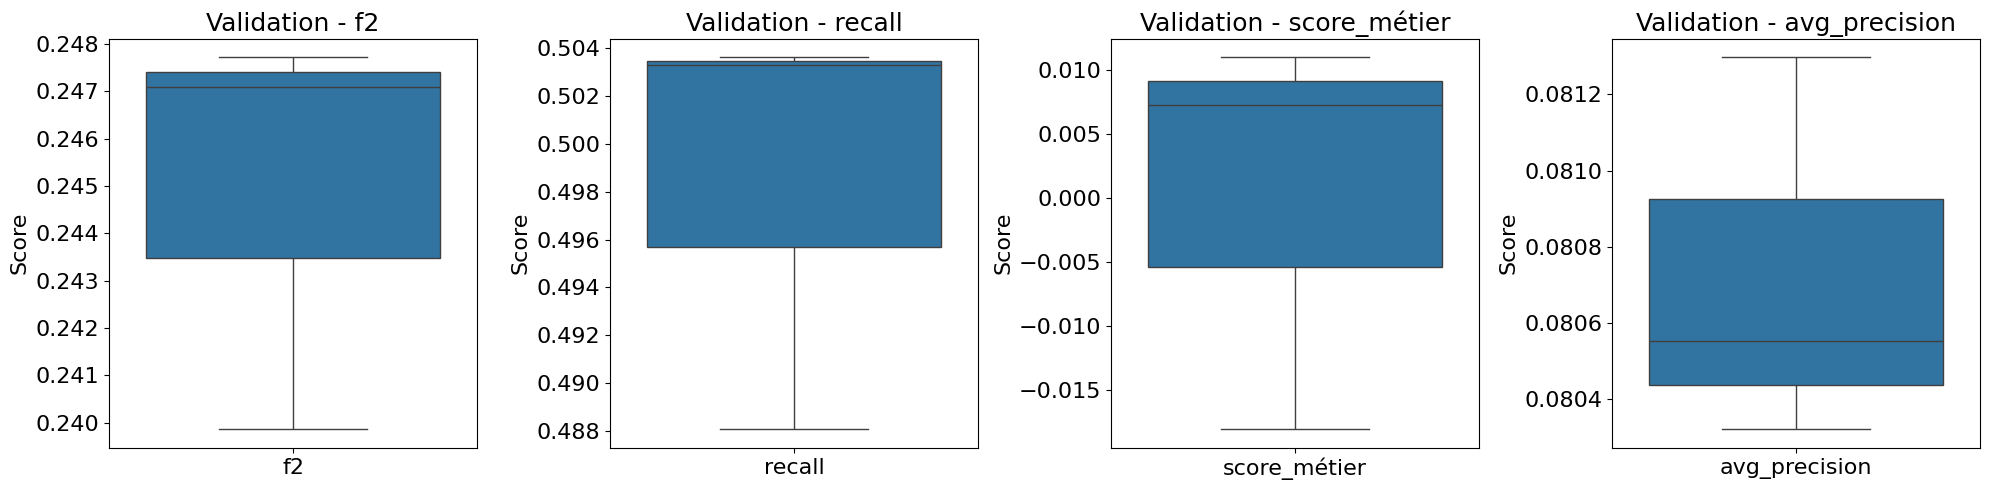

In [12]:
# Définition du modèle à utiliser
model = DummyClassifier(strategy="stratified")

# Définition de la pipeline 
pipe =ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model)
])


# Liste des scores
scoring = {
    'f2': f2_scorer,
    'recall': 'recall',
    'score_métier': custom_scorer,
    'avg_precision': 'average_precision'}

# Appel de la fonction d'évaluation
scores_d, y_test_pred_probas_d, y_test_pred_classe_d  = pipeline_evaluation(
    pipe, X_train, Y_train, scoring,
    X_test, Y_test,
    cv_splits=3, random_state=42)

In [13]:
# Visualisation des scores 
scores_d

,model,score,train_score,val_score mean,val_score std,test_score
0,DummyClassifier,f2,0.24,0.24,0.00,0.25
1,DummyClassifier,recall,0.50,0.50,0.01,0.51
2,DummyClassifier,score_métier,-0.00,0.00,0.01,0.02
3,DummyClassifier,avg_precision,0.08,0.08,0.00,0.08


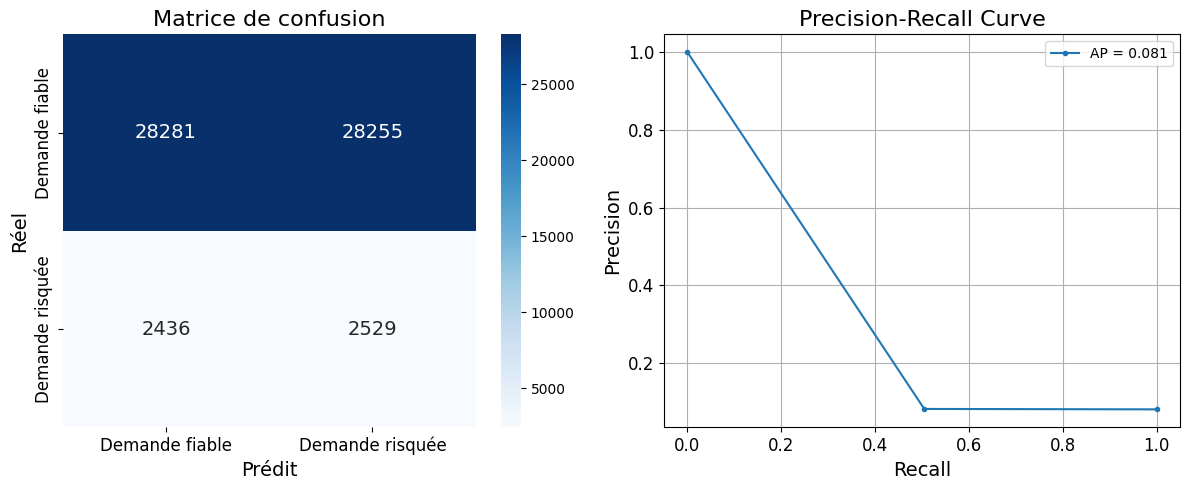

In [14]:
# Appel de la fonction permettant de visualiser la matrice de confusion et la courbe PR
plot_confmat_and_pr_curve(Y_test,  y_test_pred_classe_d, y_test_pred_probas_d, class_names=['Demande fiable', 'Demande risquée'], model_name="Dummy")

Les performances obtenues avec le modèle de classification Dummy montrent que ce modèle de référence ne permet pas de capturer la structure des données. Le score F2 (0.25) et l’average precision (0.08) sont très faibles, ce qui traduit une incapacité à identifier correctement la classe qu'on cherche à prédire et qui est minoritaire. Bien que le rappel atteigne 0.50, cette valeur reflète uniquement la stratégie utilisée par le classifieur (qui est dans ce cas de prédire une proportion fixe de positifs). Enfin, le score métier est égal à 0 ce qui montre qu'il ne permettrait pas à la société de faire des bénéfices. 

## Modèle 1 : Logistic regression

La régression logistique est un modèle statistique utilisé pour prédire une variable catégorielle à partir de plusieurs variables explicatives. Contrairement à la régression linéaire qui prédit directement une valeur, la régression logistique prédit la probabilité que l’événement se produise, grâce à une fonction appelée sigmoïde qui transforme n’importe quelle valeur en un nombre compris entre 0 et 1. Les paramètres du modèle sont estimés pour maximiser la vraisemblance des données observées. Ensuite,il permet de prédire la classe finale en appliquant un seuil sur la probabilité. Chaque coefficient du modèle indique alors l’influence de la variable correspondante sur la probabilité que l’événement se produise

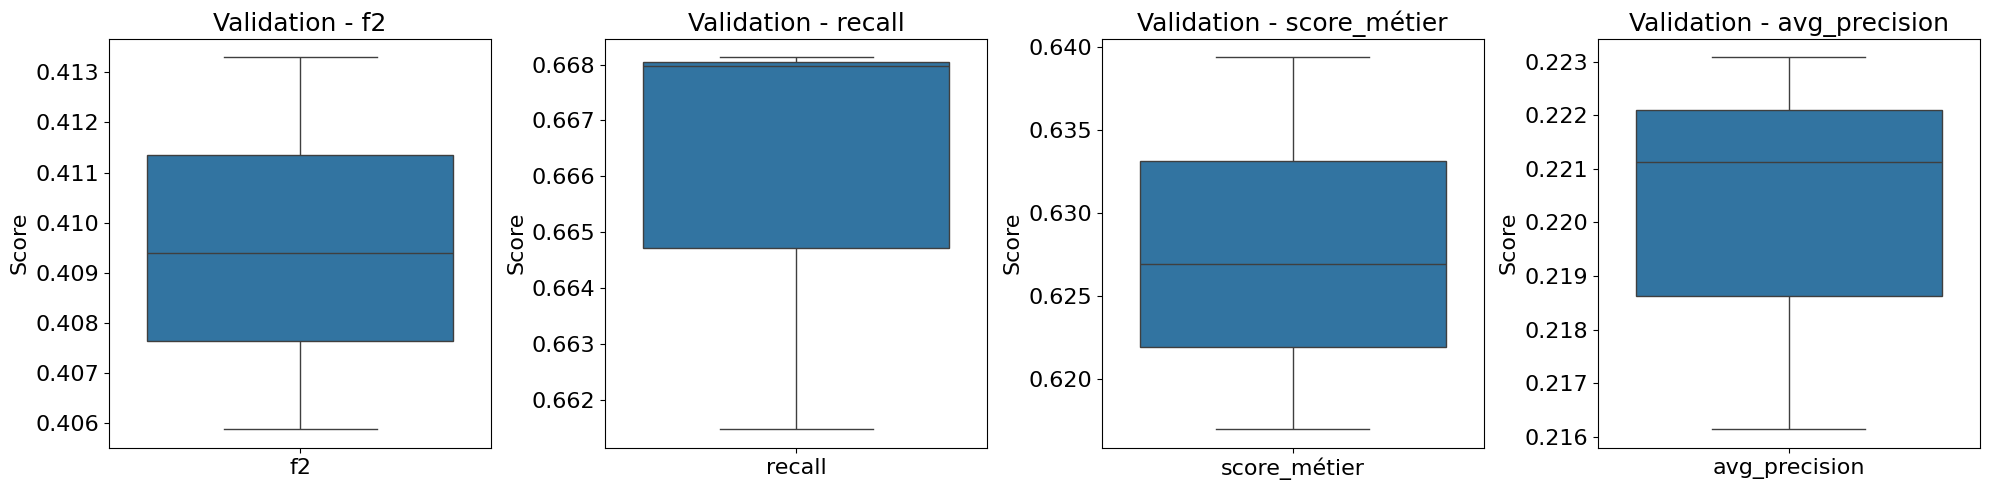

In [15]:
# Définition du modèle à utiliser
model = LogisticRegression(max_iter=1000)

# Définition de la pipeline 
pipe =ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model)
])

# Liste des scores
scoring = {
    'f2': f2_scorer,
    'recall': 'recall',
    'score_métier': custom_scorer,
    'avg_precision': 'average_precision'}


# Appel de la fonction d'évaluation
scores_lg, y_test_pred_probas_lg, y_test_pred_classe_lg  = pipeline_evaluation(
    pipe, X_train, Y_train, scoring,
    X_test, Y_test,
    cv_splits=3, random_state=42)

In [16]:
# Visualisation des scores 
scores_lg

,model,score,train_score,val_score mean,val_score std,test_score
0,LogisticRegression,f2,0.41,0.41,0.00,0.41
1,LogisticRegression,recall,0.67,0.67,0.00,0.67
2,LogisticRegression,score_métier,0.63,0.63,0.01,0.64
3,LogisticRegression,avg_precision,0.22,0.22,0.00,0.14


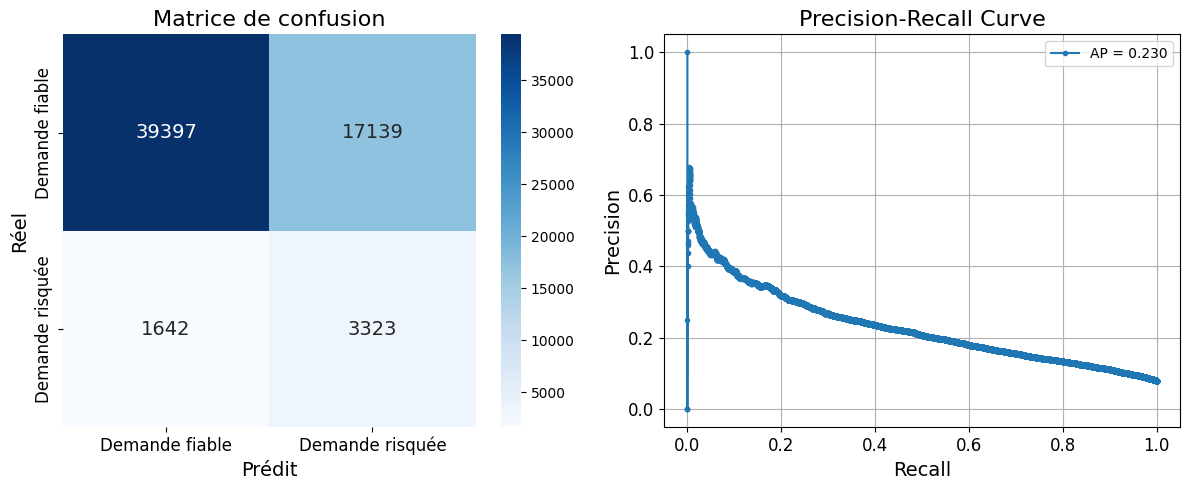

In [17]:
# Appel de la fonction permettant de visualiser la matrice de confusion et la courbe PR
plot_confmat_and_pr_curve(Y_test,  y_test_pred_classe_lg, y_test_pred_probas_lg, class_names=['Demande fiable', 'Demande risquée'], model_name="LogisticRegression")

La régression logistique montre une amélioration nette des performances de classification par rapport au modèle Dummy. Les performances sont stables entre les jeux d'entrainement, de validation et de test, ce qui signifie que le modèle ne surapprend pas et généralise correctement. 

Le score F2 obtenu (0.41) est quasiment 2 fois plus élevé que celui observé avec le modèle Dummy mais ce dernier reste faible. Ce score indique que le modèle arrive à mieux prédire les mauvais payeur mais avec encore un grand nombre de faux positifs et de faux négatifs. La précision moyenne (0.22) est aussi plus élevé mais reste faible là encore. On observe une bonne amélioration du score de rappel qui passe à 0.67 ce qui indique que 2/3 des mauvais payeurs réels sont effectivement détectés par le modèle ce qui est très positif dans le cadre de ce jeux de données où la classe minoritaire représente seulement 8% des données. Le score métier à lui aussi fortement augmenté par rapport au modèle Dummy. Ici on  observe un score positif qui indique que des bénéfices pour la société sont possibles avec ce modèle.

## Modèle 2 :  Random Forest

Le modèle RandomForest est basé sur un ensemble d'arbres de décision. Dans le cas de la classification, un arbre de décision correspondent à un modèle non linéaire qui établit ses prédictions en différentes étapes, chacune correspondant à une décision binaire. À chaque étape, appelée nœud, le modèle choisit une variable et une valeur seuil pour diviser le jeu de données en deux sous-groupes, afin que chaque sous-groupe contienne le plus possible des observations de la même classe.
Les sous groupes obtenus après les différentes étapes correspondent aux feuilles de l’arbre. La prédiction pour une observation se fait en suivant le chemin correspondant à ses caractéristiques jusqu’à la feuille finale, où la classe prédite est celle majoritaire parmi les observations de cette feuille.

Les modèles de type RandomForest consistent à entrainer plusieurs modèles en parrallèles chacun sur un échantillon différent des données d'entraînement, obtenu par bootstrap (échantillonnage aléatoire avec remise). Dans le cas d’un problème de classification, chaque arbre prédit une classe, et la prédiction finale du modèle est la classe la plus fréquente parmi tous les arbres, et utilise donc le principe de vote majoritaire.

In [ ]:
# Définition du modèle à utiliser
model = RandomForestClassifier(n_jobs=-1)

# Définition de la pipeline 
pipe =ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model)
])

# Liste des scores 
scoring = {
    'f2': f2_scorer,
    'recall': 'recall',
    'score_métier': custom_scorer,
    'avg_precision': 'average_precision'}


# Appel de la fonction d'évaluation
scores_rf, y_test_pred_probas_rf, y_test_pred_classe_rf  = pipeline_evaluation(
    pipe, X_train, Y_train, scoring,
    X_test, Y_test,
    cv_splits=3, random_state=42)

In [ ]:
# Visualisation des scores 
scores_rf

In [ ]:
# Appel de la fonction permettant de visualiser la matrice de confusion et la courbe PR
plot_confmat_and_pr_curve(Y_test,  y_test_pred_classe_rf, y_test_pred_probas_rf, class_names=['Demande fiable', 'Demande risquée'], model_name="RandomForest")

Le modèle RandomForest obtient des résultats parfaits sur les données d’entraînement, mais échoue totalement à reproduire ces performances sur les données de validation et de test. Cela signifie que le modèle a mémorisé les exemples d’entraînement sans apprendre de règles généralisables. On a donc un fort surapprentissage avec ce modèle. En validaiton, le score F2 et le score de rappel sont encore moins bon que ceux observés avec le modèle Dummy et le score métier est quant à lui légèrement supérieur tout en restant moins bon que celui observé avec le modèle de Regression Logistique.

## Modèle 3 :  Light GBM

Une autre famille de modèles basés sur des arbre de décision correspond au LightGBM utilisant le principe de gradient boosting. Cela signifie que ce modèle construit les arbres de manière itérative, chaque nouvel arbre corrigeant les erreurs commises par les arbres précédents. Pour la classification, chaque arbre prédit une probabilité pour chaque classe, et la prédiction finale correspond à la classe ayant la probabilité totale la plus élevée après combinaison de tous les arbres.

In [ ]:
# Définition du modèle à utiliser
model = lgb.LGBMClassifier(random_state=42, verbosity=-1)

# Définition de la pipeline 
pipe =ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model)
])

# Liste des scores 
scoring = {
    'f2': f2_scorer,
    'recall': 'recall',
    'score_métier': custom_scorer,
    'avg_precision': 'average_precision'}


# Appel de la fonction d'évaluation
scores_lgbm, y_test_pred_probas_lgbm, y_test_pred_classe_lgbm  = pipeline_evaluation(
    pipe, X_train, Y_train, scoring,
    X_test, Y_test,
    cv_splits=3, random_state=42)

In [ ]:
# Visualisation des scores 
scores_lgbm

In [ ]:
# Appel de la fonction permettant de visualiser la matrice de confusion et la courbe PR
plot_confmat_and_pr_curve(Y_test,  y_test_pred_classe_lgbm, y_test_pred_probas_lgbm, class_names=['Demande fiable', 'Demande risquée'], model_name="LGBM")

Dans le cas du LGBMClassifier, on retrouve des scores F2 et de rappel qui sont très faibles aussi bien en entrainement qu'en validation ou en test. Le score F2 est d'ailleurs comparable à celui obtenu avec le modèle Dummy et le RandomForest. De même, le score de rappel observé est équivalent à celui obtenu avec le RandomForest. On note une légèrement amélioration du score métier qui reste bien en dessous de celui obtenu avec le modèle de Logistique Regression. 

## Comparaison des modèles

In [ ]:
# Concaténation des résultats des différents modèles
Result_explo = pd.concat([scores_d, scores_lg, scores_rf, scores_lgbm])

# Ajout d'une variable pour identifier l'étape 
Result_explo['Optimisation'] = 'Avant'

# Affichage 
Result_explo.head()

In [ ]:
import warnings
from plotnine.exceptions import PlotnineWarning

warnings.filterwarnings("ignore", category=PlotnineWarning)


# Dictionnaire de couleurs
color_mapping = {
        'DummyClassifier': '#b3b3b3',
        'LogisticRegression': '#6ac5b4',
        'RandomForestClassifier': '#a8a9d6',
        'LGBMClassifier': '#494b9c'}

# Appel de la fonction
model_compare_graph(Result_explo, facet_xy='score ~ scoring', color_mapping=color_mapping, save_name="Comparaison des performances des modèles non optimisés")

**En résumé**:

- Le DummyClassifier qui sert de référence et prédit selon la proportion des deux classes présente des performances très limitées. Ses scores F2 et de rappel sont faibles (environ 0,25 et 0,50), et sa valeur métier est nulle. Il est stable mais n’a aucun pouvoir prédictif.

- Au contraire, la régression logistique est nettement meilleure. Elle atteint un F2 d’environ 0,41 et un rappel de 0,67, avec un score métier autour de 0,64 et un Average Precision de 0,23. Le modèle est stable, généralise bien et apporterait à la société un modèle leur permettant de faire des bénéfices.

- Le RandomForestClassifier montre un overfitting très important : il prédit parfaitement sur l’entraînement (F2 et rappel à 1,0) mais échoue presque complètement sur validation et test (F2 et recall ~ 0,01). Son score métier est très faible sur le test, ce qui le rend inutilisable sans régularisation ou ajustement des hyperparamètres.

- Le LGBMClassifier, avec ses paramètres par défaut, a des performances très faibles (F2 et rappel autour de 0,02-0,03, score métier avoisinant 0,14). Bien qu’il soit stable et n’overfit pas, il n’apprend quasiment rien et est moins performant que la Régression Logistique.

Dans cette partie, les modèles ont été instanciés avec leur paramètres par défaut ce qui a permis une première évaluation de leur capacité de prédiction. Dans l'étape suivante ces modèles seront optimisés pour identifier les combinaisons de paramètres qui maximisent le plus leurs performances.

# Modélisation: optimisation

L'étape d'optimisation des modèles de classifation explorés dans la partie précédente se fera en deux temps. 
- Dans une première étape, les paramètres des modèles tout comme ceux de la phase de rééchantillonnage via SMOTE seront optimisés pour déterminer la meilleure combinaison de paramètre c'est à dire celle qui permet de maximiser les capacités de prédiction des modèles. Afin de rester aligner avec les objectifs du projet, l'optimisation se fera grâce à l'évaluation du score métier permettant de pénaliser plus les faux négatifs que les faux positifs. Pour cela, on utilisera la bibliothèque optuna qui explore l'espace des hyperparamètres en testant et en comparant différentes combinaisons pour trouver celle qui donne les meilleurs résulats de performance. Les essais seront guidés par une approche bayésienne, permettant à l’algorithme de proposer intelligemment de nouvelles combinaisons de paramètres en se basant sur les performances des essais précédents.
- Dans un second temps, le seuil de classification sera également ajusté dans le même but: maximiser le score métier.

## Fonctions

L'optimisation des différents modèles et la visualisaiton des résultats se fera à l'aide de plusieurs fonctions.
- La première fonction permettra d'optimiser les hyperparamètres de la pipeline via l'outil optuna et le score métier
- La deuxième fonction permettra d'optimiser le seuil de classification en faisant varier le seuil et en caculant le score métier pour chacun de ces seuils
- La troisième fonction permettra de visualiser l'impact que les différents paramètres ont eu lors de l'optimisation et de visualiser l'évolution du score en fonction des différents éssaie. Ces fonctions sont déjà inclus dans optuna mais seront redéfinies ici afin de pouvoir afficher les deux figures cote à cote.

L’optimisation sera suivie avec MLflow. Pour cela, une nouvelle expérience sera créée pour chaque optimisation. À l’intérieur de cette expérience, un run parent regroupera tous les paramètres et les scores de performance associés au modèle. Les différents essais d’optimisation seront enregistrés sous forme de nested runs rattachés au run parent, ce qui permettra de visualiser et comparer facilement leurs résultats dans l’interface MLflow.
Le modèle final sera également enregistré dans MLflow qui stockera l’ensemble des fichiers nécessaires à sa réutilisation : artefacts du modèle (fichiers pickle, environnement conda.yaml, MLmodel), métriques, paramètre. On pourra également sauvegarder certaines figures sur MLFlow.

In [26]:
# Configuration de optuna pour n'afficher que les message d'avertissement ou d'erreurs
optuna.logging.set_verbosity(logging.WARNING)

In [27]:
def optimisation_hyperparametres(pipeline, X, y, param_distributions,
                                 scoring,n_trials=20, n_splits=3):
    
    """
    Optimise les hyperparamètres d'un modèle au sein d'une pipeline en utilisant Optuna et effectue 
    le suivi des essais via MLflow.

    Cette fonction crée une étude Optuna, explore l'espace des hyperparamètres défini dans 
    un dictionnaire passé en paramètres effectue une validation croisée pour évaluer les performances et logge 
    les résultats et paramètres testés dans MLflow. 
    
    Paramètres
        pipeline (sklearn.pipeline): Pipeline contenant différentes étapes dont le modèle
        X (pandas.DataFrame): Features d'entrée pour l'entraînement.
        y (pandas.Series): Variable cible.
        param_distributions (dict) : Dictionnaire définissant les hyperparamètres à tester.  
        scoring (str ou callable): Fonction de scoring utilisée pour évaluer les performances lors de la validation croisée.
        n_trials (int, default=20): Nombre d'essais Optuna pour l'optimisation des hyperparamètres.
        n_splits (int, default=3): Nombre de splits pour la validation croisée.

    Sortie
        study (optuna.study.Study): Objet Study contenant les résultats de l'optimisation
    """
    
    # Désactivation de l'affichage d'information
    set_verbosity(WARNING)
    
    # Initialisation d'une barre de progression
    progbar = Progbar(n_trials, stateful_metrics=["score"])

    # Construction de la fonction objectif pour optuna
    def objective(trial):
        
        # Initialisation du dictionnaire stockant les paramètres à tester    
        params = {}
        
        # Pour chaque paramètres
        for param_name, param_info in param_distributions.items():
            
            # Si trois valeurs de type numérique, choisir une valeur aléatoirement entre le min et le max
            if len(param_info) == 3:
                ptype, vmin, vmax = param_info
                val = (trial.suggest_int(param_name, vmin, vmax)
                        if ptype == 'int' else trial.suggest_float(param_name, vmin, vmax))
            
            # Si deux valeurs de type catégoriel, choisir une valeur aléatoirement
            elif len(param_info) == 2:
                ptype, choices = param_info
                if ptype != 'categorical':
                    raise ValueError(f"Type non supporté : {ptype}")
                val = trial.suggest_categorical(param_name, choices)
            else:
                raise ValueError(f"Format incorrect : {param_info}")
            
            # Ajout de la valeur choisie dans le dictionnaire
            params[param_name] = val
        
        # Lancement d'un run enfant pour chaque essai
        with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True):
            
            # Mise a jour de la pipeline avec la combinaison de paramètres définie
            pipeline.set_params(**params)

            # Stratigie de découpage pour la cross validation
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            
            # Calcul du score de validation
            score = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1).mean()

            # Log des paramètres testés
            mlflow.log_params(params)
            
            # Log du score métier associé
            mlflow.log_metric("Score_métier", score)
            
            # Mise a jour de la barre de progression
            progbar.update(trial.number + 1, values=[("score", score)])
            
            return score

    # Initialisation de l'étude optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    
    # Optimisation des paramètres
    study.optimize(objective, n_trials=n_trials)

    # Affichage du score de validation avant optimisation du seuil
    print(f"Score de validation avant optimisation du seuil : {study.best_value:.3f}")

    return study



In [28]:
def optimisation_seuil(pipeline, X_train, y_train, X_test, y_test, scoring,
                       study, n_splits=3, n_seuils=50, model_name=None):
    """
    Optimise le seuil sur validation croisée, calcule les scores train, val, test,
    log dans MLflow (modèle, métriques, figure) et renvoie une dataframe qui 
    récapitule l'ensemble des résultats.
    
    Paramètres:
        pipeline (sklearn.pipeline): Pipeline sklearn
        X_train, y_train : données train
        X_test, y_test : données test
        scoring (str ou callable): Fonction de scoring utilisée pour évaluer les performances lors de la validation croisée.
        study (optuna.study.Study): Objet Study contenant les résultats de l'optimisation
        n_splits (int, default=3): Nombre de splits pour la validation croisée.
        n_seuils (int, default=50): Nombre seuils à tester.
        model_name (str) : Nom du modèle pour MLflow
        extra_metrics (dict, default=None): Dictionnaire de métriques supplémentaires 

    Sortie:
        results_df (pandas.DataFrame): Dataframe résumé des scores et paramètres
        pipeline (sklearn.pipeline): pipeline entraîné
        fig : figure matplotlib du score en fonction du seuil
    """
    
    # Identification du meilleur seuil par validation croisée
    # ---------------------------------------------------------------------------------------
    
    # Application des meilleurs hyperparamètres
    pipeline.set_params(**study.best_params)

    # Optimisation du seuil via CV
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    probas = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    
    # Création d'une plage de seuils à évaluer
    seuils = np.linspace(0.01, 0.99, n_seuils)
    
    # Ajout du seuil 0.5
    if 0.5 not in seuils:
        seuils = np.sort(np.append(seuils, 0.5))
    
    # Initialisation des variables
    best_score = -np.inf
    best_seuil = 0.5
    scores_par_seuil = []
    best_y_pred_val = None 

    # Pour chaque seuil
    for s in seuils:
        
        # Prédiction de la classe
        y_pred = (probas >= s).astype(int)
        
        # Calcul du score
        score = scoring(y_train, y_pred)
        
        # Ajout du score dans la liste de résultat
        scores_par_seuil.append(score)
        
        # Si le meilleur score est battu
        if score > best_score:
            
            # Mise à jour du meilleur score
            best_score = score
            
            # Mise à jour du meilleur seuil
            best_seuil = s
            
            # Sauvegarde des prédictions val associées
            best_y_pred_val = y_pred
            
    # Calcul des scores finaux sur les jeux d'entrainement, de validation et de test
    # ---------------------------------------------------------------------------------------
    
    print(f"\n>>>> Evaluation des performances")

    # Entrainement final sur tout le train
    pipeline.fit(X_train, y_train)
        
    # Scores sur le jeu d'entrainement
    probas_train = pipeline.predict_proba(X_train)[:, 1]
    y_pred_train = (probas_train >= best_seuil).astype(int)
    train_score = scoring(y_train, y_pred_train)
    avg_prec_train = average_precision_score(y_train, probas_train)
    recall_train = recall_score(y_train, y_pred_train)
    
    # Score sur le jeu de validation
    val_score = best_score
    avg_prec_val = average_precision_score(y_train, probas)
    recall_val = recall_score(y_train, best_y_pred_val)

    # Score sur le jeu de test
    probas_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (probas_test >= best_seuil).astype(int)
    test_score = scoring(y_test, y_pred_test)
    avg_prec_test = average_precision_score(y_test, probas_test)
    recall_test = recall_score(y_test, y_pred_test)
    
    # Affichage des résultats principaux
    # ---------------------------------------------------------------------------------------

    print(f"Train: {train_score:.3f}, \nValidation CV: {best_score:.3f}, \nTest: {test_score:.3f}")
    print(f"Seuil optimal final : {best_seuil:.3f}")

    
    # Sauvegarde MLFlow
    # ---------------------------------------------------------------------------------------

    # Création de la signature du modèle
    signature = infer_signature(sample_X, pipeline.predict(sample_X))
    
    # Log du modèle
    mlflow.sklearn.log_model(pipeline, name = model_name, 
                                    registered_model_name=f'{model_name} optimisé',
                                    input_example=sample_X,
                                    signature=signature)
    
    # Log métriques et paramètres
    mlflow.log_params(study.best_params)
    mlflow.log_metric("train_score_final", train_score)
    mlflow.log_metric("val_score_cv_final", best_score)
    mlflow.log_metric("test_score_final", test_score)
    mlflow.log_metric("best_threshold", best_seuil)
    
    # Log des nouvelles métriques
    mlflow.log_metric("train_avg_precision", avg_prec_train)
    mlflow.log_metric("train_recall", recall_train)
    mlflow.log_metric("val_avg_precision", avg_prec_val)
    mlflow.log_metric("val_recall", recall_val)
    mlflow.log_metric("test_avg_precision", avg_prec_test)
    mlflow.log_metric("test_recall", recall_test)
    
    # Sauvegarde des scores dans une dataframe
    # ---------------------------------------------------------------------------------------

    # Création de la dataframe résultats
    results_df = pd.DataFrame({
        'model': [model_name]*3,
        'best_params': [str(study.best_params)]*3,
        'best_seuil': [best_seuil]*3,
        "score": ["score_métier", "recall", "avg_precision"],
        "train_score": [train_score, recall_train, avg_prec_train],
        "val_score": [val_score, recall_val, avg_prec_val],
        "test_score": [test_score, recall_test, avg_prec_test]
    })


    # Construction d'une figure
    # ---------------------------------------------------------------------------------------

    # Création de la figure représentant les scores en fonction des seuils
    fig, ax = plt.subplots()
    ax.plot(seuils, scores_par_seuil, marker='o')
    ax.set_xlabel("Seuil de décision")
    ax.set_ylabel("Score métier (validation CV)")
    ax.set_title("Score métier en fonction du seuil de décision")
    ax.grid(True)
    plt.close(fig)
    
    # Log de la figure
    mlflow.log_figure(fig, f"plots/{model_name}_threshold_optimization.png")
  
    return results_df, pipeline, fig


In [29]:
def plot_optuna_summary(study):

    """
    Affiche deux représentations graphiques des résultats d'une étude Optuna :
        1. L'importance relative des hyperparamètres optimisés.
        2. L'historique de la valeur de l'objectif par essai, avec suivi de la meilleure
           valeur atteinte au cours de l'optimisation.

    Paramètres
        study (optuna.study): Objet Study généré par Optuna après une optimisation.
    """
        
        
    # Extraction de l'importance des paramètres 
    importances = get_param_importances(study)
    
    # Conversion en dataframe et tri selon l'importance la plus élevée
    importance_df = pd.DataFrame({
        'parameter': list(importances.keys()),
        'importance': list(importances.values())
    }).sort_values("importance", ascending=False)

    # Extraction de l'historique de l'optimisation
    history_df = pd.DataFrame({
        'essai': [t.number for t in study.trials if t.value is not None],
        'value': [t.value for t in study.trials if t.value is not None]
    })
    
    # Calcul du meilleur score obtenu à un essai donné
    history_df["best_value_so_far"] = history_df["value"].cummax()

    # Initialisation de la figure
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Graph 1: Importance des paramètres
    sns.barplot(data=importance_df, x="importance", y="parameter", ax=axs[0])
    axs[0].set_title("Importance des paramètres testés")
    axs[0].set_xlabel("Score métier")
    axs[0].set_ylabel("Paramètres")

    # Graph 2: Historique + best value
    sns.lineplot(data=history_df, x="essai", y="value", marker="o", label="Objective Value", ax=axs[1], color = "blue")
    sns.lineplot(data=history_df, x="essai", y="best_value_so_far", label="Best Value So Far", ax=axs[1], color="red")
    axs[1].set_title("Historique de l'optimisation")
    axs[1].set_xlabel("Numéro de l'essai")
    axs[1].set_ylabel("Score métier")
    axs[1].legend()
    
    # Ajustement de la figure
    plt.tight_layout()
    
    # Affichage de la figure
    plt.show()


## Première optimisation des hyperparamètres et du seuil de classification

Avant de démarrer l’optimisation des différents modèles, un échantillon des données d’entrée sera généré. Cet échantillon sera enregistré avec le modèle final lors de l’étape d’enregistrement, afin de servir d’exemple d’entrée et de documenter le format attendu par le modèle. Les variables de type int seront converties en float, car le prétraitement inclut une étape de standardisation qui transforme systématiquement les int en float. Le modèle s’attend donc à recevoir ce type de données en entrée. La conversion garantit donc la cohérence entre l’entraînement, l’enregistrement et l’utilisation ultérieure du modèle.

In [30]:
# Échantillon brut
sample_X = X_train.sample(5).copy()

# Conversion forcée des int -> float
sample_X[sample_X.select_dtypes("integer").columns] = sample_X.select_dtypes("integer").astype("float64")

In [31]:
# Défition du chemin local de stockage
mlflow.set_tracking_uri("../mlflow/mlruns")

Pour optimiser les différents modèles, plusieurs plage de valeurs à tester seront définies et permettront de tester plusieurs combinaison de paramètres relatifs à la fois à la phase de rééchantillonnage mais surtout à la phase de modélisation.

- **SMOTE**: on pourra tester la proprotion de rééchantillonage (*sampling_strategy*), et le nombre de voisin à prendre en compte pour générer de nouvelles observations synthétiques (*K_neighboor*)
- **Regression Logistique** : on pourra tester la force de la régularisation (*C*), le type de pénalité (*penalty*), le ratio de régularisation L1/L2 (l1_ratio) et la pondération des classes (*class_weight*)
- **RandomForest** : on pourra tester la profondeur maximale des arbres (*max_depth*), le nombre d'arbres (*n_estimators*), le nombre minimal d'échantillon requis pour effectuer un split (*min_sample_split*), le nombre minimal d'échantillons par feuille (*min_sample_leaf*), et la pondération des classes (*class_weight*)
- **LightGBM** : on pourra tester le nombre d'arbre (*n_estimators*), le taux d'apprentissage (*learning_rate*), le pourcentage d'observation à inclure dans chaque arbre (*subsample*), le pourcentage de variable à utiliser dans chaque arbre (*col_sample_bytree*), la complexité de l'arbre via le nombre de feuilles (*num_leaves*), la régularisation L1 (*reg_alpha*), la régularisation L2 (*reg_lambda*) et la pondération des classes (*class_weight*).

In [32]:
# Définition du dictionnaire de paramètres à tester
model_param_distributions = {
    
    'LogisticRegression': (
        LogisticRegression(random_state=42, max_iter=1500, solver='saga', n_jobs=-1),
        {
            'smote__sampling_strategy': ('float', 0.5, 1.0),
            'smote__k_neighbors': ('int', 3, 10),
            'feature_selection__threshold': ('categorical', ['mean', 'median', 0.001, 0.01, 0.05]),
            'clf__C': ('float', 1e-4, 100),
            'clf__penalty': ('categorical', ['l1', 'l2']),
            'clf__class_weight': ('categorical', [None, 'balanced'])
        }),
    
        'RandomForestClassifier': (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            'smote__sampling_strategy': ('float', 0.5, 1.0),
            'smote__k_neighbors': ('int', 3, 7),
            'clf__n_estimators': ('int', 50, 100),
            'clf__max_depth': ('int', 3, 30),
            'clf__min_samples_split': ('int', 2, 10),
            'clf__min_samples_leaf': ('int', 1, 10),
            'clf__max_features': ('categorical', ['sqrt', 'log2', None]),
            'clf__class_weight': ('categorical', [None, 'balanced', 'balanced_subsample'])
        }),
        
        'LGBMClassifier': (
    lgb.LGBMClassifier(random_state=42, verbosity=-1),
    {
        'smote__sampling_strategy': ('float', 0.5, 1.0),
        'smote__k_neighbors': ('int', 3, 10),
        'clf__n_estimators': ('int', 50, 100),
        'clf__max_depth': ('int', 3, 15),
        'clf__learning_rate': ('float', 0.01, 0.3),
        'clf__subsample': ('float', 0.5, 1.0),
        'clf__colsample_bytree': ('float', 0.5, 1.0),
        'clf__num_leaves': ('int', 20, 150),
        'clf__min_child_samples': ('int', 5, 30),
        'clf__reg_alpha': ('float', 0.0, 5.0),
        'clf__reg_lambda': ('float', 0.0, 5.0),
        'clf__class_weight': ('categorical', [None, 'balanced'])})
}

# Création d'une expérience à tracker
mlflow.set_experiment(f'Première optimisation des modèles avec Optuna - {date_str}')
  
# Initialisation des dataframes et dictionnaires stockant les résultats
results = {}
results_opt_df_final = pd.DataFrame()
pipelines = {}
figs = {}

# Pour chaque modèle et grille de paramètres
for name, (model, param_dist) in model_param_distributions.items():
    
    # Définition de la pipeline
    pipe = ImbPipeline([
        ('preprocessing', preprocessor),
        ('feature_selection', SelectFromModel(model)),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    # Affichage du nom du modèle en cours de test
    print("--------------------------------------------------------------------")
    print(f"       Optimisation du modèle : {name}       ")
    print("--------------------------------------------------------------------")
    print(f"\n>>>> Optimisation des hyperperamètres de la pipeline")

    
    with mlflow.start_run(run_name=f'Optimisation: {model}') as parent_run:

        # Appel de la fonction d'optimisation des paramètres
        study = optimisation_hyperparametres(
            pipeline=pipe,
            param_distributions = param_dist,
            X=X_train, y=Y_train,
            scoring = custom_scorer,
            n_trials=20, n_splits=3)
        
        print(f"\n>>>> Optimisation du seuil")

        # Appel de la fonction d'optimisation du seuil
        results_df, pipe_fited, fig = optimisation_seuil(
            pipe, X_train, Y_train, X_test, Y_test, score_metier, study, 
            n_splits=3, n_seuils=50, model_name=name)

        # Ajout des résultats du modèle à la dataframe
        results_opt_df_final = pd.concat([results_opt_df_final, results_df], ignore_index=True)

        # Ajout de l'étude du modèle au dictionnaire
        results[name] = study

        # Ajout de la pipeline au dictionnaire
        pipelines[name] = pipe_fited
        
        # Stockage de la figure par modèle
        figs[name] = fig

# Sauvegarde des résultats
joblib.dump(results, f"../Output/Optuna_study/optuna_results_{date_str}.joblib")
results_opt_df_final.to_csv(f"../Output/Optimisation_results_df/optimisaiton_df_{date_str}.csv", index=False)
joblib.dump(pipelines, f"../Output/Pipelines/pipelines_{date_str}.joblib")
joblib.dump(figs, f"../Output/Figures/Optimisation_seuil_{date_str}.joblib")  

2025/09/08 22:56:25 INFO mlflow.tracking.fluent: Experiment with name 'Première optimisation des modèles avec Optuna - 2025-09-08_22-53-58' does not exist. Creating a new experiment.


--------------------------------------------------------------------
       Optimisation du modèle : LogisticRegression       
--------------------------------------------------------------------

>>>> Optimisation des hyperperamètres de la pipeline
20/20 ━━━━━━━━━━━━━━━━━━━━ 14182s 720s/step - score: 0.6282
Score de validation avant optimisation du seuil : 0.630

>>>> Optimisation du seuil

>>>> Evaluation des performances
Train: 0.637, 
Validation CV: 0.634, 
Test: 0.643
Seuil optimal final : 0.530


Successfully registered model 'LogisticRegression optimisé'.
Created version '1' of model 'LogisticRegression optimisé'.


--------------------------------------------------------------------
       Optimisation du modèle : RandomForestClassifier       
--------------------------------------------------------------------

>>>> Optimisation des hyperperamètres de la pipeline
20/20 ━━━━━━━━━━━━━━━━━━━━ 2172s 112s/step - score: 0.3203
Score de validation avant optimisation du seuil : 0.516

>>>> Optimisation du seuil

>>>> Evaluation des performances
Train: 0.532, 
Validation CV: 0.526, 
Test: 0.539
Seuil optimal final : 0.550


Successfully registered model 'RandomForestClassifier optimisé'.
Created version '1' of model 'RandomForestClassifier optimisé'.


--------------------------------------------------------------------
       Optimisation du modèle : LGBMClassifier       
--------------------------------------------------------------------

>>>> Optimisation des hyperperamètres de la pipeline
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - score: 0.2519
Score de validation avant optimisation du seuil : 0.277

>>>> Optimisation du seuil

>>>> Evaluation des performances
Train: 0.600, 
Validation CV: 0.585, 
Test: 0.604
Seuil optimal final : 0.230


Successfully registered model 'LGBMClassifier optimisé'.
Created version '1' of model 'LGBMClassifier optimisé'.


['../Output/Figures/Optimisation_seuil_2025-09-08_22-53-58.joblib']

In [33]:
# Chargement du fichier
results = joblib.load(f"../Output/Optuna_study/optuna_results_{date_str}.joblib")
results_opt_df_final = pd.read_csv(f"../Output/Optimisation_results_df/optimisaiton_df_{date_str}.csv")
pipelines = joblib.load(f"../Output/Pipelines/pipelines_{date_str}.joblib")
figs = joblib.load(f"../Output/Figures/Optimisation_seuil_{date_str}.joblib")

# Ajout de la variable optimisation
results_opt_df_final['Optimisation']='Optimisation 1'

# Visualisation de la table de résultats
results_opt_df_final

,model,best_params,best_seuil,score,train_score,val_score,test_score,Optimisation
0,LogisticRegression,"{'smote__sampling_strategy': 0.56391216214132,...",0.53,score_métier,0.637464,0.634188,0.643339,Optimisation 1
1,LogisticRegression,"{'smote__sampling_strategy': 0.56391216214132,...",0.53,recall,0.629708,0.628348,0.630614,Optimisation 1
2,LogisticRegression,"{'smote__sampling_strategy': 0.56391216214132,...",0.53,avg_precision,0.223183,0.220496,0.231460,Optimisation 1
3,RandomForestClassifier,{'smote__sampling_strategy': 0.843863055449285...,0.55,score_métier,0.531654,0.525768,0.538625,Optimisation 1
4,RandomForestClassifier,{'smote__sampling_strategy': 0.843863055449285...,0.55,recall,0.557301,0.550705,0.560926,Optimisation 1
5,RandomForestClassifier,{'smote__sampling_strategy': 0.843863055449285...,0.55,avg_precision,0.171864,0.168034,0.177984,Optimisation 1
6,LGBMClassifier,{'smote__sampling_strategy': 0.599836891079179...,0.23,score_métier,0.600213,0.584555,0.604315,Optimisation 1
7,LGBMClassifier,{'smote__sampling_strategy': 0.599836891079179...,0.23,recall,0.602669,0.607754,0.602820,Optimisation 1
8,LGBMClassifier,{'smote__sampling_strategy': 0.599836891079179...,0.23,avg_precision,0.212003,0.203618,0.212819,Optimisation 1


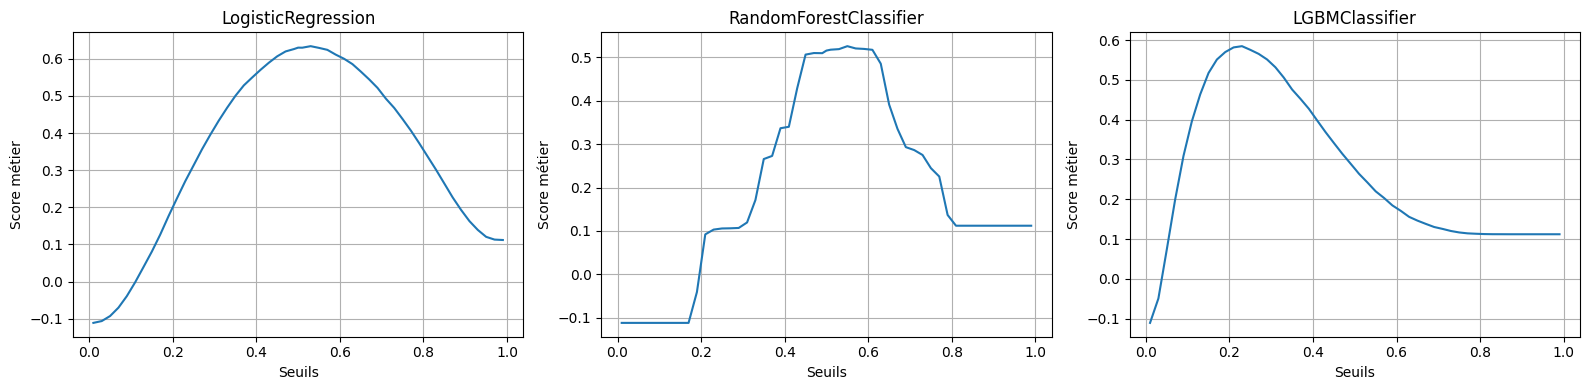

In [34]:
# Création de la figure
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

# Pour chaque plot
for ax, (model_name, fig_model) in zip(axes, figs.items()):
    
    # Extraction de la figure
    ax_model = fig_model.get_axes()[0]
    
    # Reconstruction de la figure
    for line in ax_model.get_lines():
        x = line.get_xdata()
        y = line.get_ydata()
        ax.plot(x, y, label=line.get_label())
    
    # Ajout d'un titre a chacun des plots
    ax.set_title(model_name)
    
    # Ajout d'une grille
    ax.grid(True)
    
    # Ajout du label X 
    ax.set_xlabel("Seuils")
    
    # Ajout du label Y
    ax.set_ylabel("Score métier")

# Ajustement de la figure
plt.tight_layout()

# Sauvegarde de la figure
plt.savefig(f'../Output/Evolution_seuil_classification/Evolution_seuil_classification_opt1.png', format='png')

# Affichage de la figure
plt.show()


Pour chacun des trois modèles, la courbe représentant l'évolution du score métier en fonction du seuil de classification a un forme plus ou moins parabolique avec un maximum relativement centré pour deux des modèles. Le maximum est en effet atteint autour du seuil 0.5 pour les modèles de Régression Logistique et de RandomForest tandis que le seuil de classification associé au score métier optimal du modèle LGBM se situe vers 0.20. Ce seuil a d'ailleur permis une forte augmentation du score métier par rapport au seuil classique de 0.50.

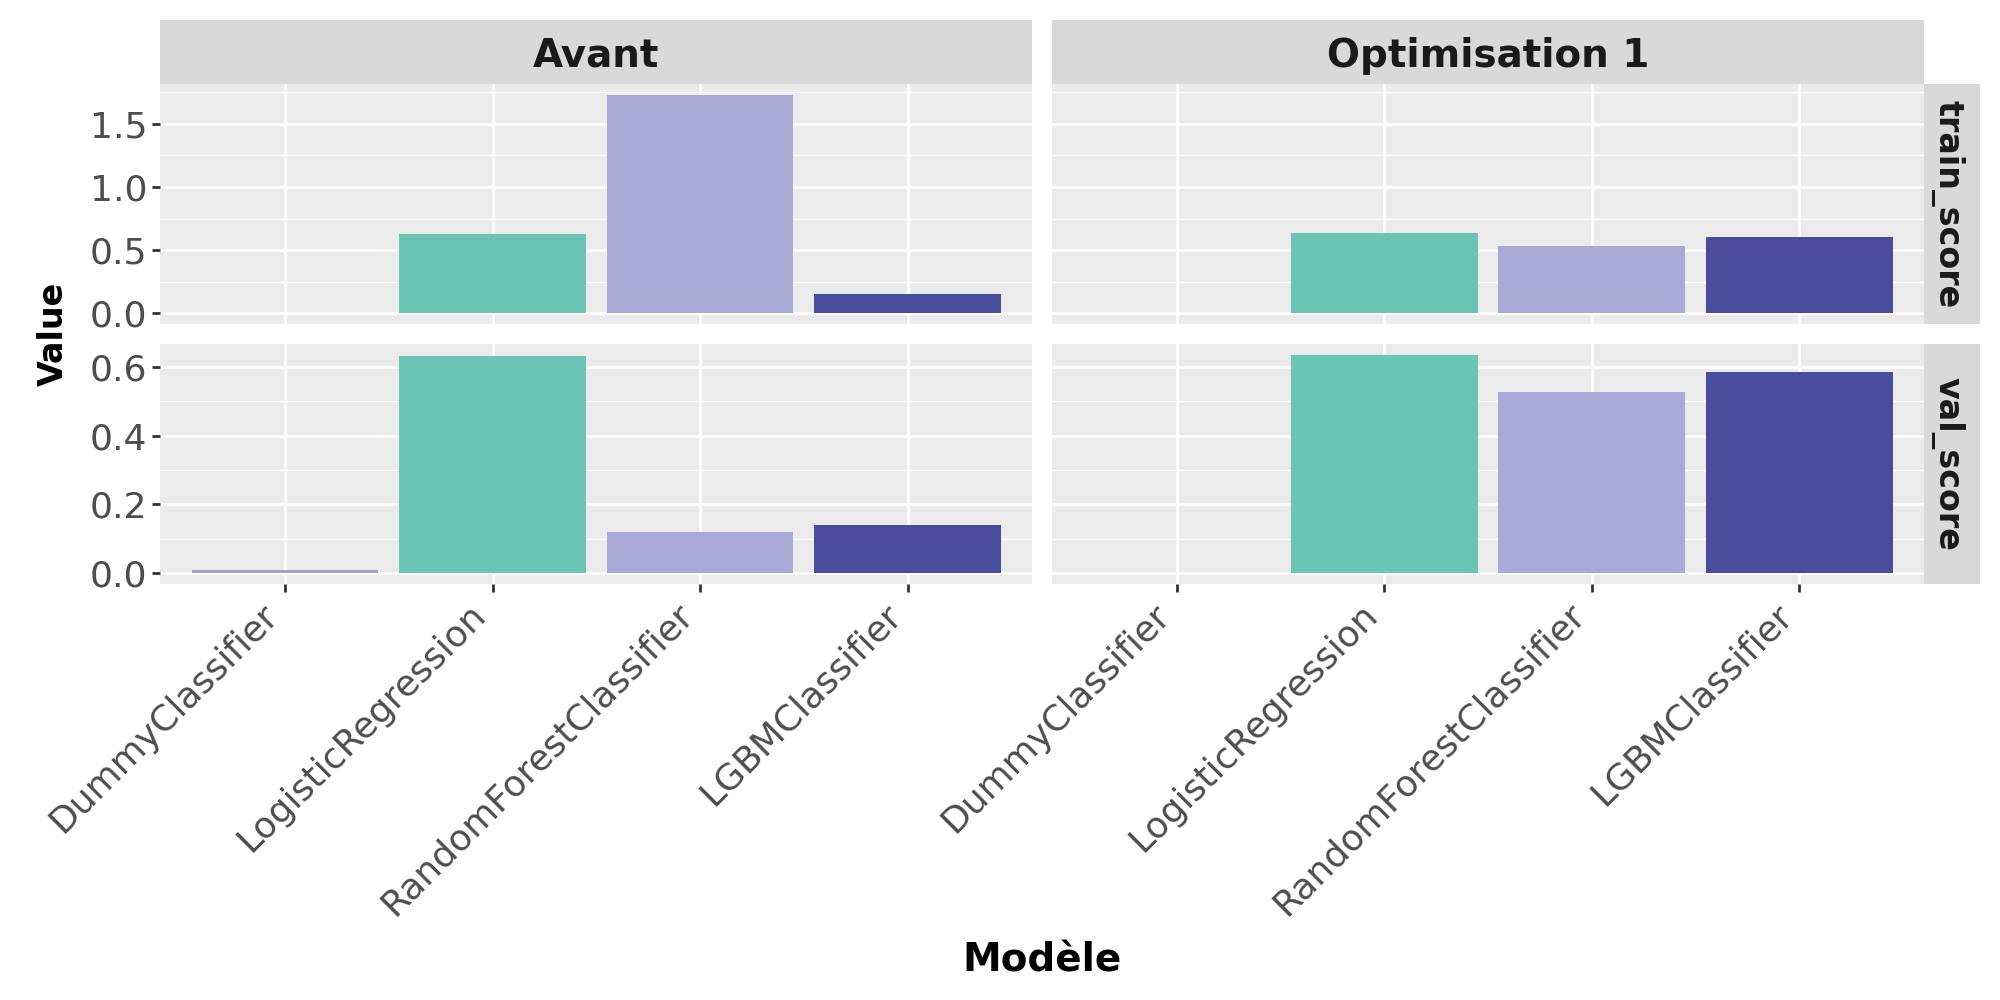

In [35]:
# Modification du nom de la variable val score dans la table d'exploration
Result_explo['val_score'] = Result_explo['val_score mean']

# Définition des variables à conserver dans les différentes tables
Feature_explo = ['model', 'score', 'val_score', 'train_score', 'Optimisation']
Feature_opt = ['model', 'score', 'val_score', 'train_score', 'Optimisation']
    
# Concaténation des table résultats avant et après
results_df_final = pd.concat([Result_explo[Feature_explo], results_opt_df_final[Feature_opt]])

# Filtre pour ne garder que les lignes corresondant au score métier
results_df_final_plot_metier = results_df_final[results_df_final['score']=='score_métier']

# Création d'un dictionnaire de mapping couleur - modèle
color_mapping = {
        'DummyClassifier': '#a3a3c2',
        'LogisticRegression': '#6ac5b4',
        'RandomForestClassifier': '#a8a9d6',
        'LGBMClassifier': '#494b9c'}

# Appel de la fonction pour comparer les résultats
model_compare_graph(results_df_final_plot_metier, facet_xy='scoring ~ Optimisation', color_mapping=color_mapping, save_name="Comparaison_performances(score_metier)_modèles_optimisation1")


La première phase d'optimisation a permis d'améliorer significativement la performance des modèles de RandomForest et de LGBM qui sont passé d'un score métier de respectivement 0.12 et 0.14 à respectivement 0.52 et 0.58. Au contraire, acuune amélioration notable du score métier n'est observée pour le modèle de Régression Logistique qui est un modèle plus difficile a optimiser. On note également que cette première phase d'optimisation a permis de réduire très fortement l'overfit du modèle random forest qui était présent avant optimisation. Compte tenu de la marge de progression obtenu avec les modèles RandomForest et LGBM, on peut essayer d'améliorer davantage leur performance lors d'une deuxième phase d'optimisation. 

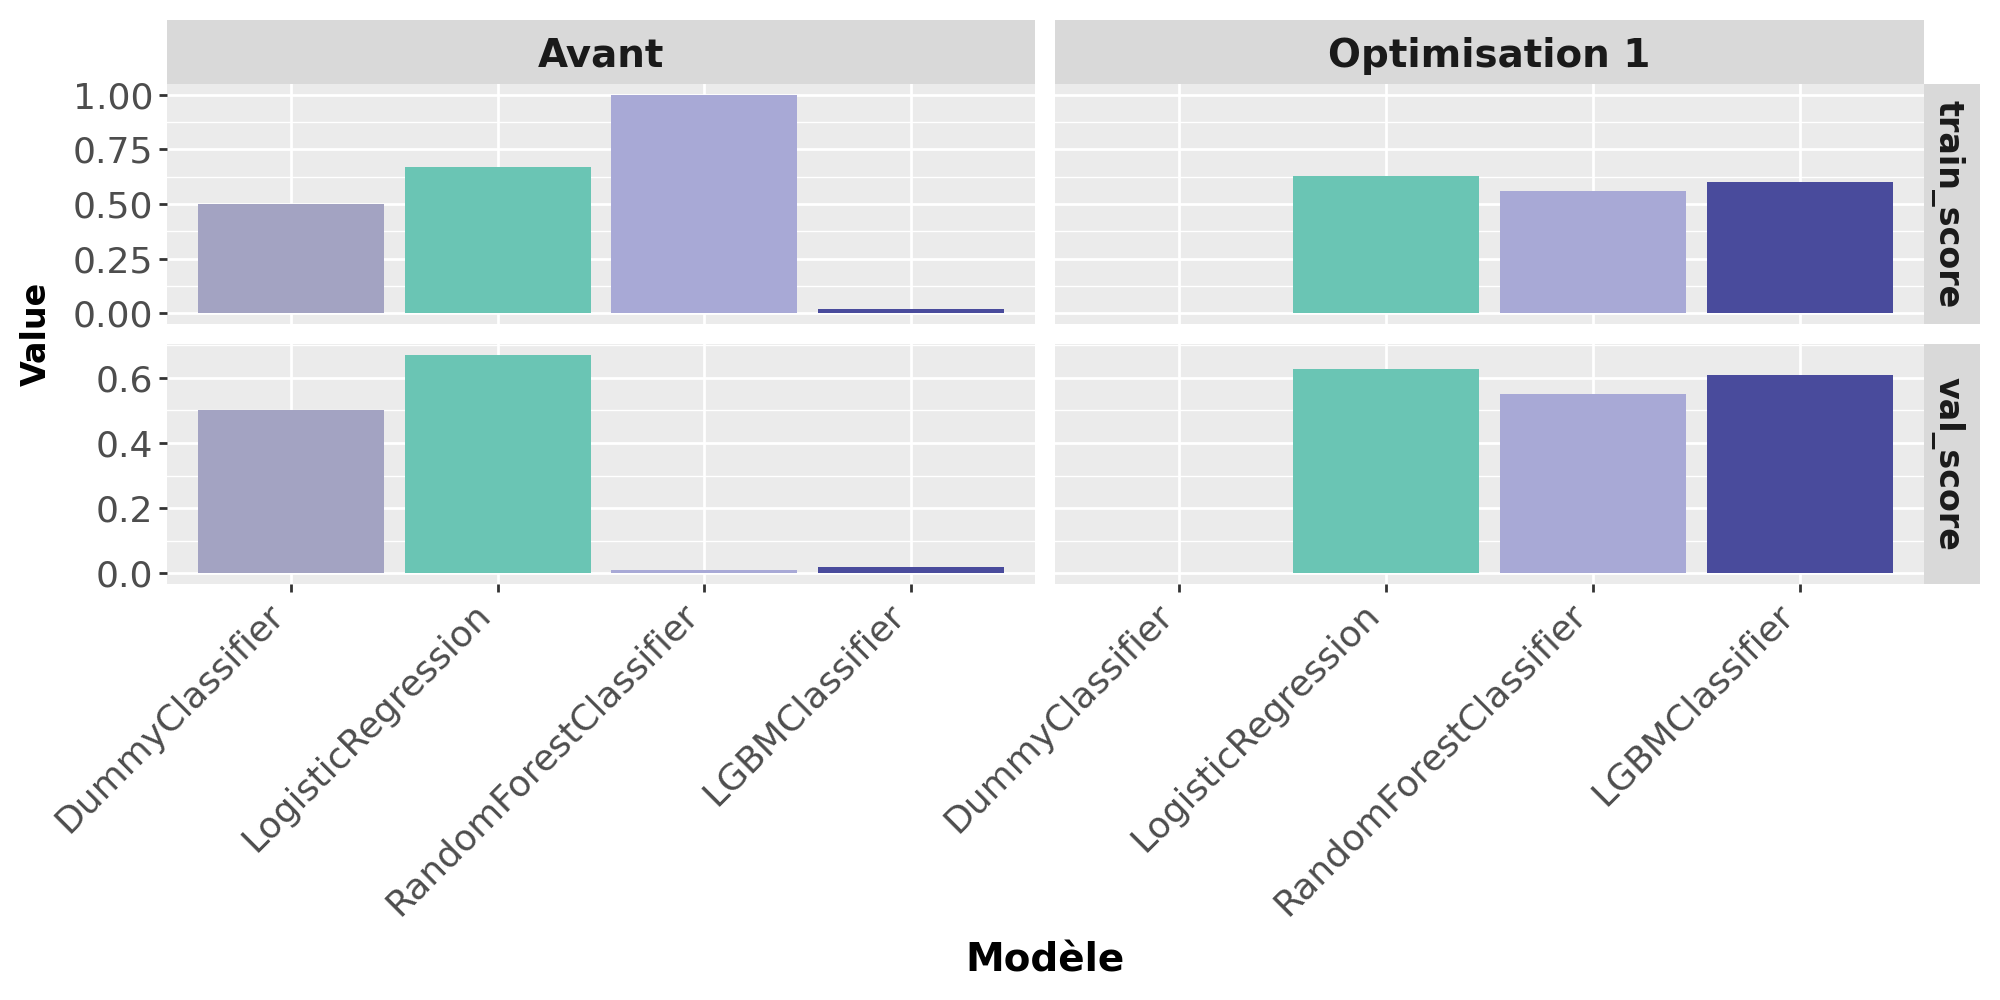

In [36]:
# Modification du nom de la variable val score dans la table d'exploration
Result_explo['val_score'] = Result_explo['val_score mean']

# Définition des variables à conserver dans les différentes tables
Feature_explo = ['model', 'score', 'val_score', 'train_score', 'Optimisation']
Feature_opt = ['model', 'score', 'val_score', 'train_score', 'Optimisation']
    
# Concaténation des table résultats avant et après
results_df_final = pd.concat([Result_explo[Feature_explo], results_opt_df_final[Feature_opt]])

# Filtre pour ne garder que les lignes corresondant au score métier
results_df_final_plot_recall = results_df_final[results_df_final['score']=='recall']

# Création d'un dictionnaire de mapping couleur - modèle
color_mapping = {
        'DummyClassifier': '#a3a3c2',
        'LogisticRegression': '#6ac5b4',
        'RandomForestClassifier': '#a8a9d6',
        'LGBMClassifier': '#494b9c'}

# Appel de la fonction pour comparer les résultats
model_compare_graph(results_df_final_plot_recall, facet_xy='scoring ~ Optimisation', color_mapping=color_mapping, save_name="Comparaison_performances(recall)_modèles_optimisation1")


## Analyse des scores associés aux différentes combinaisons testées

MLFlow fournit des graphiques particulièrement utiles pour la phase d'optimisation des modèles. Notemment, le parallel coordinates plot permet de visualiser chaque combinaison testée avec un code couleur représentant le score d'optimisation obtenu. On va donc s'en servir pour la deuxieme phase d'optimisation en repérant pour chaque paramètres les zones pour lesquelles les meilleurs score ont été obtenus. Cela permettra d'ajuster les zone de recherches en resserant certaines zone, en augmentant ou en diminuant certains seuil de ces zones. 

Pour chacun des deux modèles RandomForest et LGBM, le parallel coordinate plot associé sera visualisé puis un tableau récapitulant les anciennes plages testése, les zones associées au meilleurs résultats ainsi que les nouvelles plages qui seront testées pour chaque paramètres sera affiché.

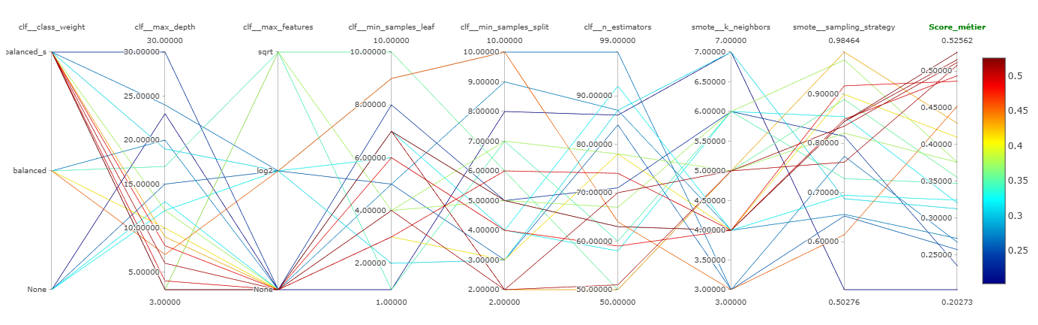

In [37]:
# Affichage de la figure mlflow
display(Image(filename='../Images/Optimisation_RandomForest.png'))

Lors de la première phase d'optimisation du modèle de RandomForest, 8 hyperparamètres ont été explorés. Certains d'entre eux ont montré des valeurs conduisant à des scores métiers plus élevés. C'est notamment le cas de l'hyperparamètre class_weight, pour lequel la valeur balanced_subsample a globalement fourni les meilleurs résultats. Pour la seconde phase d'optimisation, cet hyperparamètre pourra donc être fixé à balanced_subsample, afin d'éviter d'explorer des combinaisons avec les autres valeurs qui n'ont pas montré de performances satisfaisantes en moyenne. De même, les meilleurs scores métiers ont été obtenus lorsque max_depth était inférieur à 10. La zone de recherche pour cette hyperparamètre pourra donc être resserrée pour se concentrer sur des valeurs inférieures à ce seuil. Par ailleurs, la valeur 2 n'ayant pas été inclus lors de la première phase d'optimisation, elle sera ajoutée à la plage de recherche de la seconde phase.

Le même raisonnement a été appliqué aux autres hyperparamètres afin d'ajuster les plages de recherche et de définir de nouvelles zones adaptées pour la seconde phase d'optimisation. De même, cette approche a aussi également été appliquée au modèle LightGBM.

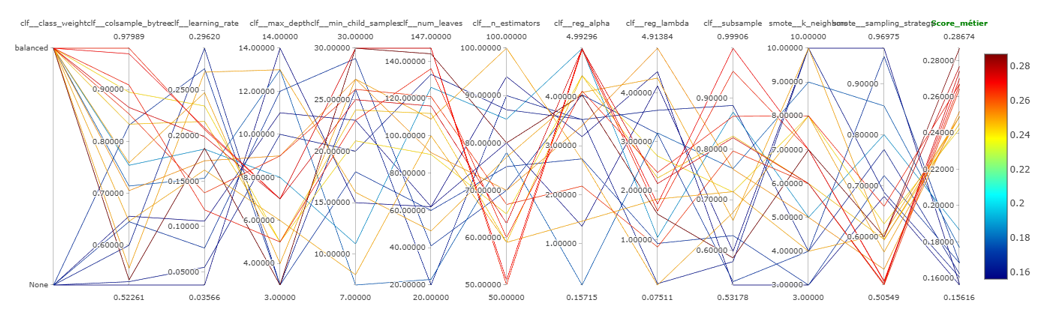

In [38]:
# Affichage de la figure mlflow
display(Image(filename='../Images/Optimisation_LightGBM.png'))

## Deuxième optimisation de RandomForest et LGBM

In [39]:
# Désactivation des warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names*")

# Définition du dictionnaire de paramètres à tester
model_param_distributions = {
    
    'RandomForestClassifier': (
    RandomForestClassifier(random_state=42, n_jobs=-1),
    {
        'smote__sampling_strategy': ('float', 0.5, 1.0),
        'smote__k_neighbors': ('int', 3, 6),
        'clf__n_estimators': ('int', 50, 300),
        'clf__max_depth': ('int', 2, 10),
        'clf__min_samples_split': ('int', 2, 10),
        'clf__min_samples_leaf': ('int', 1, 10),
        'clf__max_features': ('categorical', [None, 'log2', 0.5, 0.7]),
        'clf__class_weight': ('categorical', ['balanced_subsample']),
        'clf__min_impurity_decrease': ('float', 0.0, 0.05),
        'clf__ccp_alpha': ('float', 0.0, 0.01),
    }), 

    'LGBMClassifier': (
    lgb.LGBMClassifier(random_state=42, verbosity=-1),
    {
        'smote__sampling_strategy': ('float', 0.4, 0.5),
        'smote__k_neighbors': ('int', 5, 7),
        'clf__n_estimators': ('int', 30, 70),
        'clf__max_depth': ('int', 7, 10),
        'clf__learning_rate': ('float', 0.15, 0.25),
        'clf__subsample': ('float', 0.9, 0.98),
        'clf__colsample_bytree': ('float', 0.85, 0.95),
        'clf__num_leaves': ('int', 120, 200),
        'clf__min_child_samples': ('int', 5, 14),
        'clf__reg_alpha': ('float', 4.0, 10.0),
        'clf__reg_lambda': ('float', 2.0, 3.0),
        'clf__class_weight': ('categorical', ['balanced'])

    })}

# Création d'une expérience à tracker
mlflow.set_experiment(f'Deuxième optimisation modèles avec Optuna - {date_str}')
  
# Initialisation des dataframes et dictionnaires stockant les résultats
results_2 = {}
results_opt_df_final_2 = pd.DataFrame()
pipelines_2 = {}
figs_2 = {}

# Pour chaque modèle et grille de paramètres
for name, (model, param_dist) in model_param_distributions.items():
    
    # Définition de la pipeline
    pipe = ImbPipeline([
        ('preprocessing', preprocessor),
        ('feature_selection', SelectFromModel(model)),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)])

    # Affichage du nom du modèle en cours de test
    print("--------------------------------------------------------------------")
    print(f"       Optimisation du modèle : {name}       ")
    print("--------------------------------------------------------------------")
    print(f"\n>>>> Optimisation des hyperperamètres de la pipeline")
    
    with mlflow.start_run(run_name=f'Optimisation: {model}') as parent_run:

        # Appel de la fonction d'optimisation des paramètres
        study = optimisation_hyperparametres(
            pipeline=pipe,
            param_distributions = param_dist,
            X=X_train, y=Y_train,
            scoring = custom_scorer,
            n_trials=40,
            n_splits=3)

        # Appel de la fonction d'optimisation du seuil
        results_df_2, pipe_fited_2, fig_2 = optimisation_seuil(
        pipe, X_train, Y_train, X_test, Y_test, score_metier, study, n_splits=3, n_seuils=50, model_name=name)

        # Ajout des résultats du modèle à la datagrame
        results_opt_df_final_2 = pd.concat([results_opt_df_final_2, results_df_2], ignore_index=True)

        # Ajout de l'étude du modèle au dictionnaire
        results_2[name] = study

        # Ajout de la pipeline au dictionaire
        pipelines_2[name] = pipe_fited_2
        
        # Stockage de la figure par modèle
        figs_2[name] = fig_2

# Sauvegarde des résultats
joblib.dump(results_2, f"../Output/Optuna_study/optuna_results_2_{date_str}.joblib")
results_opt_df_final_2.to_csv(f"../Output/Optimisation_results_df/optimisaiton_df_2_{date_str}.csv", index=False)
joblib.dump(pipelines_2, f"../Output/Pipelines/pipelines_2_{date_str}.joblib")
joblib.dump(figs_2, f"../Output/Figures/Optimisation_seuil_2_{date_str}.joblib")  

2025/09/09 03:59:30 INFO mlflow.tracking.fluent: Experiment with name 'Deuxième optimisation modèles avec Optuna - 2025-09-08_22-53-58' does not exist. Creating a new experiment.


--------------------------------------------------------------------
       Optimisation du modèle : RandomForestClassifier       
--------------------------------------------------------------------

>>>> Optimisation des hyperperamètres de la pipeline
40/40 ━━━━━━━━━━━━━━━━━━━━ 4156s 106s/step - score: 0.2063
Score de validation avant optimisation du seuil : 0.522

>>>> Evaluation des performances
Train: 0.520, 
Validation CV: 0.522, 
Test: 0.521
Seuil optimal final : 0.500


Registered model 'RandomForestClassifier optimisé' already exists. Creating a new version of this model...
Created version '2' of model 'RandomForestClassifier optimisé'.


--------------------------------------------------------------------
       Optimisation du modèle : LGBMClassifier       
--------------------------------------------------------------------

>>>> Optimisation des hyperperamètres de la pipeline
40/40 ━━━━━━━━━━━━━━━━━━━━ 248s 6s/step - score: 0.3670
Score de validation avant optimisation du seuil : 0.370

>>>> Evaluation des performances
Train: 0.670, 
Validation CV: 0.586, 
Test: 0.611
Seuil optimal final : 0.270


Registered model 'LGBMClassifier optimisé' already exists. Creating a new version of this model...
Created version '2' of model 'LGBMClassifier optimisé'.


['../Output/Figures/Optimisation_seuil_2_2025-09-08_22-53-58.joblib']

In [40]:
# Chargement du fichier
results_2 = joblib.load(f"../Output/Optuna_study/optuna_results_2_{date_str}.joblib")
results_opt_df_final_2 = pd.read_csv(f"../Output/Optimisation_results_df/optimisaiton_df_2_{date_str}.csv")
pipelines_2 = joblib.load(f"../Output/Pipelines/pipelines_2_{date_str}.joblib")
figs_2 = joblib.load(f"../Output/Figures/Optimisation_seuil_2_{date_str}.joblib")

# Ajout de la variable étape
results_opt_df_final_2['Optimisation']='Optimisation 2'

# Visualisation de la table de résultats
results_opt_df_final_2

,model,best_params,best_seuil,score,train_score,val_score,test_score,Optimisation
0,RandomForestClassifier,{'smote__sampling_strategy': 0.790515318520907...,0.50,score_métier,0.520264,0.522231,0.520544,Optimisation 2
1,RandomForestClassifier,{'smote__sampling_strategy': 0.790515318520907...,0.50,recall,0.543454,0.566969,0.544411,Optimisation 2
2,RandomForestClassifier,{'smote__sampling_strategy': 0.790515318520907...,0.50,avg_precision,0.158212,0.157725,0.160487,Optimisation 2
3,LGBMClassifier,{'smote__sampling_strategy': 0.422951645788562...,0.27,score_métier,0.670431,0.585506,0.611210,Optimisation 2
4,LGBMClassifier,{'smote__sampling_strategy': 0.422951645788562...,0.27,recall,0.684189,0.633132,0.650352,Optimisation 2
5,LGBMClassifier,{'smote__sampling_strategy': 0.422951645788562...,0.27,avg_precision,0.234418,0.201462,0.215767,Optimisation 2


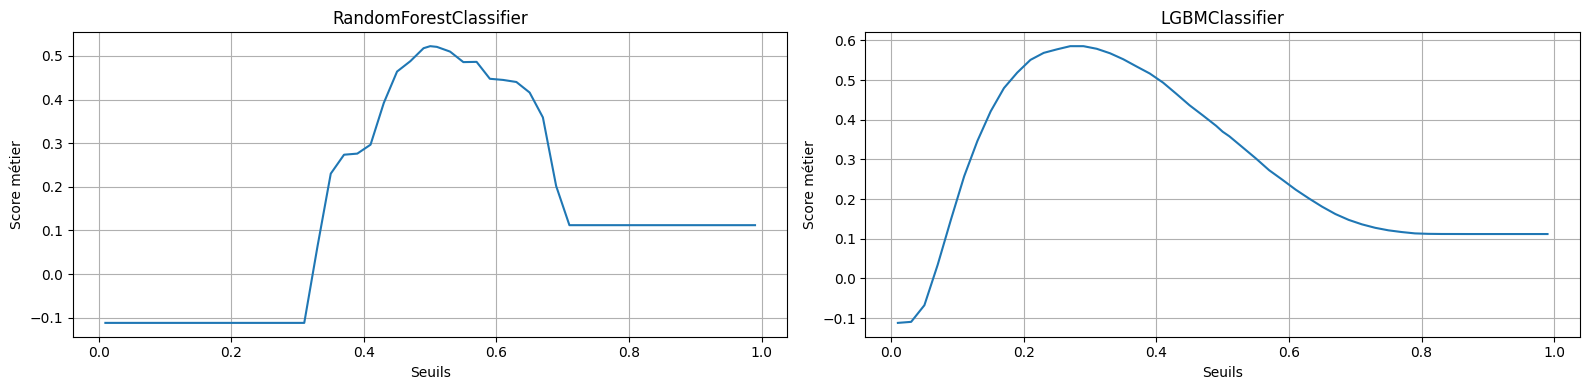

In [41]:
# Création de la figure
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True)

# Pour chaque plot
for ax, (model_name, fig_model) in zip(axes, figs_2.items()):
    
    # Extraction de la figure
    ax_model = fig_model.get_axes()[0]
    
    # Reprend toutes les courbes de cet axe pour les tracer dans le subplot
    for line in ax_model.get_lines():
        x = line.get_xdata()
        y = line.get_ydata()
        ax.plot(x, y, label=line.get_label())
    
    # Ajout d'un titre a chacun des plots
    ax.set_title(model_name)
    
    # Ajout d'une grille
    ax.grid(True)
    
    # Ajout du label X 
    ax.set_xlabel("Seuils")
    
    # Ajout du label Y
    ax.set_ylabel("Score métier")
    

# Ajustement de la figure
plt.tight_layout()

# Sauvegarde de la figure
plt.savefig(f'../Output/Evolution_seuil_classification/Evolution_seuil_classification_opt2.png', format='png')

# Affichage de la figure
plt.show()


À l’issue de la deuxième phase d’optimisation, les courbes décrivant l’évolution du score métier en fonction du seuil de classification conservent une forme similaire à celles obtenues lors de la première phase. Le seuil optimal du modèle RandomForest reste proche de 0,5, tandis que celui du LightGBM se situe désormais autour de 0,3

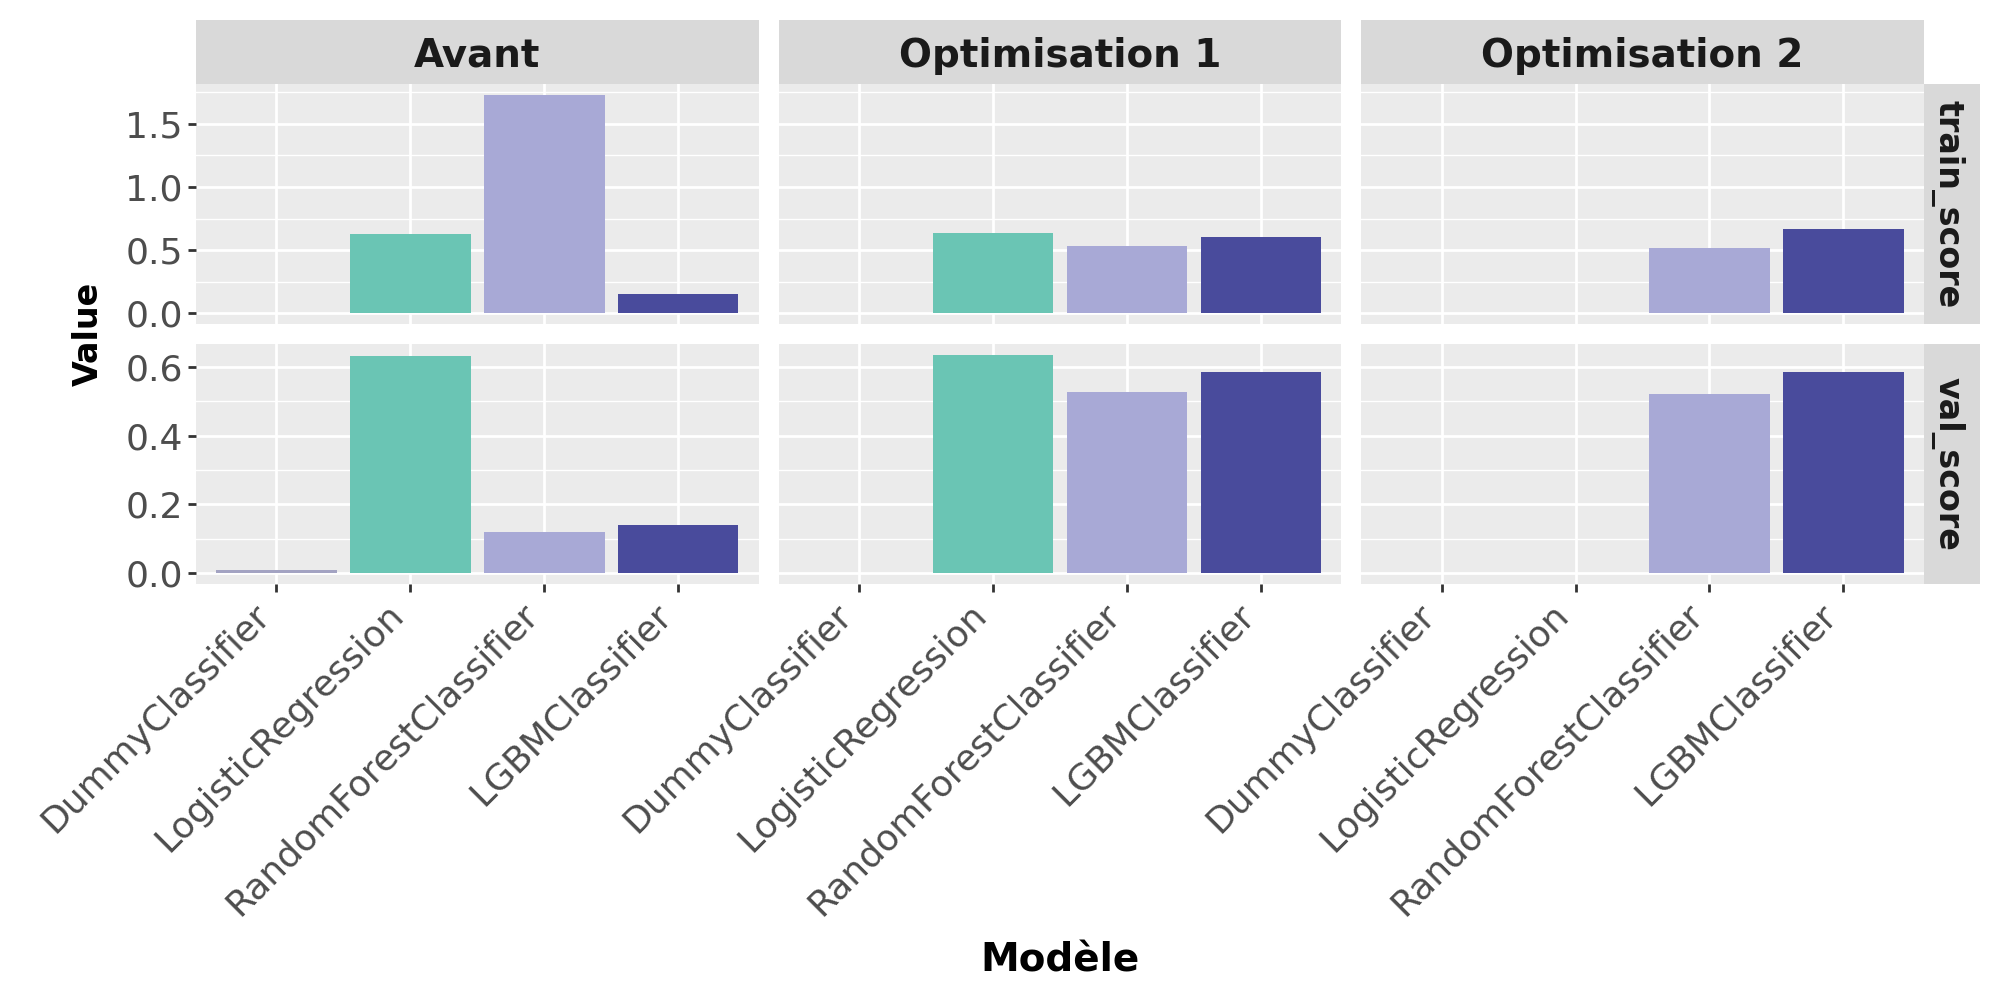

In [42]:
# variable à conserver pour le plot
Feature_opt = ['model', 'score', 'val_score', 'train_score', 'Optimisation']

# Filtre de la seconde table d'optimisation
results_opt_df_final_2_metier = results_opt_df_final_2[results_opt_df_final_2['score']=='score_métier']

# Concat des résultats avant et après la deuxième phase d'optimisation
results_df_final_plot_metier = pd.concat([results_df_final_plot_metier, results_opt_df_final_2_metier[Feature_opt]])

# Définition d'un dictionnaire de correpsondance couleur - modèle
color_mapping = {
        'DummyClassifier': '#a3a3c2',
        'LogisticRegression': '#6ac5b4',
        'RandomForestClassifier': '#a8a9d6',
        'LGBMClassifier': '#494b9c'}

# Appel de la fonction
model_compare_graph(results_df_final_plot_metier, facet_xy='scoring ~ Optimisation', color_mapping=color_mapping, save_name="Comparaison_performances(Score_métier)_modèles_optimisation2")

La deuxième phase d’optimisation n’a pas conduit à une amélioration des scores métiers pour les deux modèles testés. Le modèle de régression logistique reste celui qui présente les meilleures performances, avec un score métier supérieur à 0,60, confirmant ainsi sa robustesse par rapport aux autres modèles évalués. Néanmoins son temps d'entrainement nettement plus long que celui du modèle Light GBM qui est particulièrement rapide à entrainer oriente le choix du modèle vers ce dernier. En effet, le light GBM permet d'obtenir des performances similaires en un temps d'entrainement bien plus court. Dans la section suivante, un bilan détaillé de l’optimisation de ce modèle sera présenté, ainsi qu’une analyse plus approfondie des performances de ce modèle.

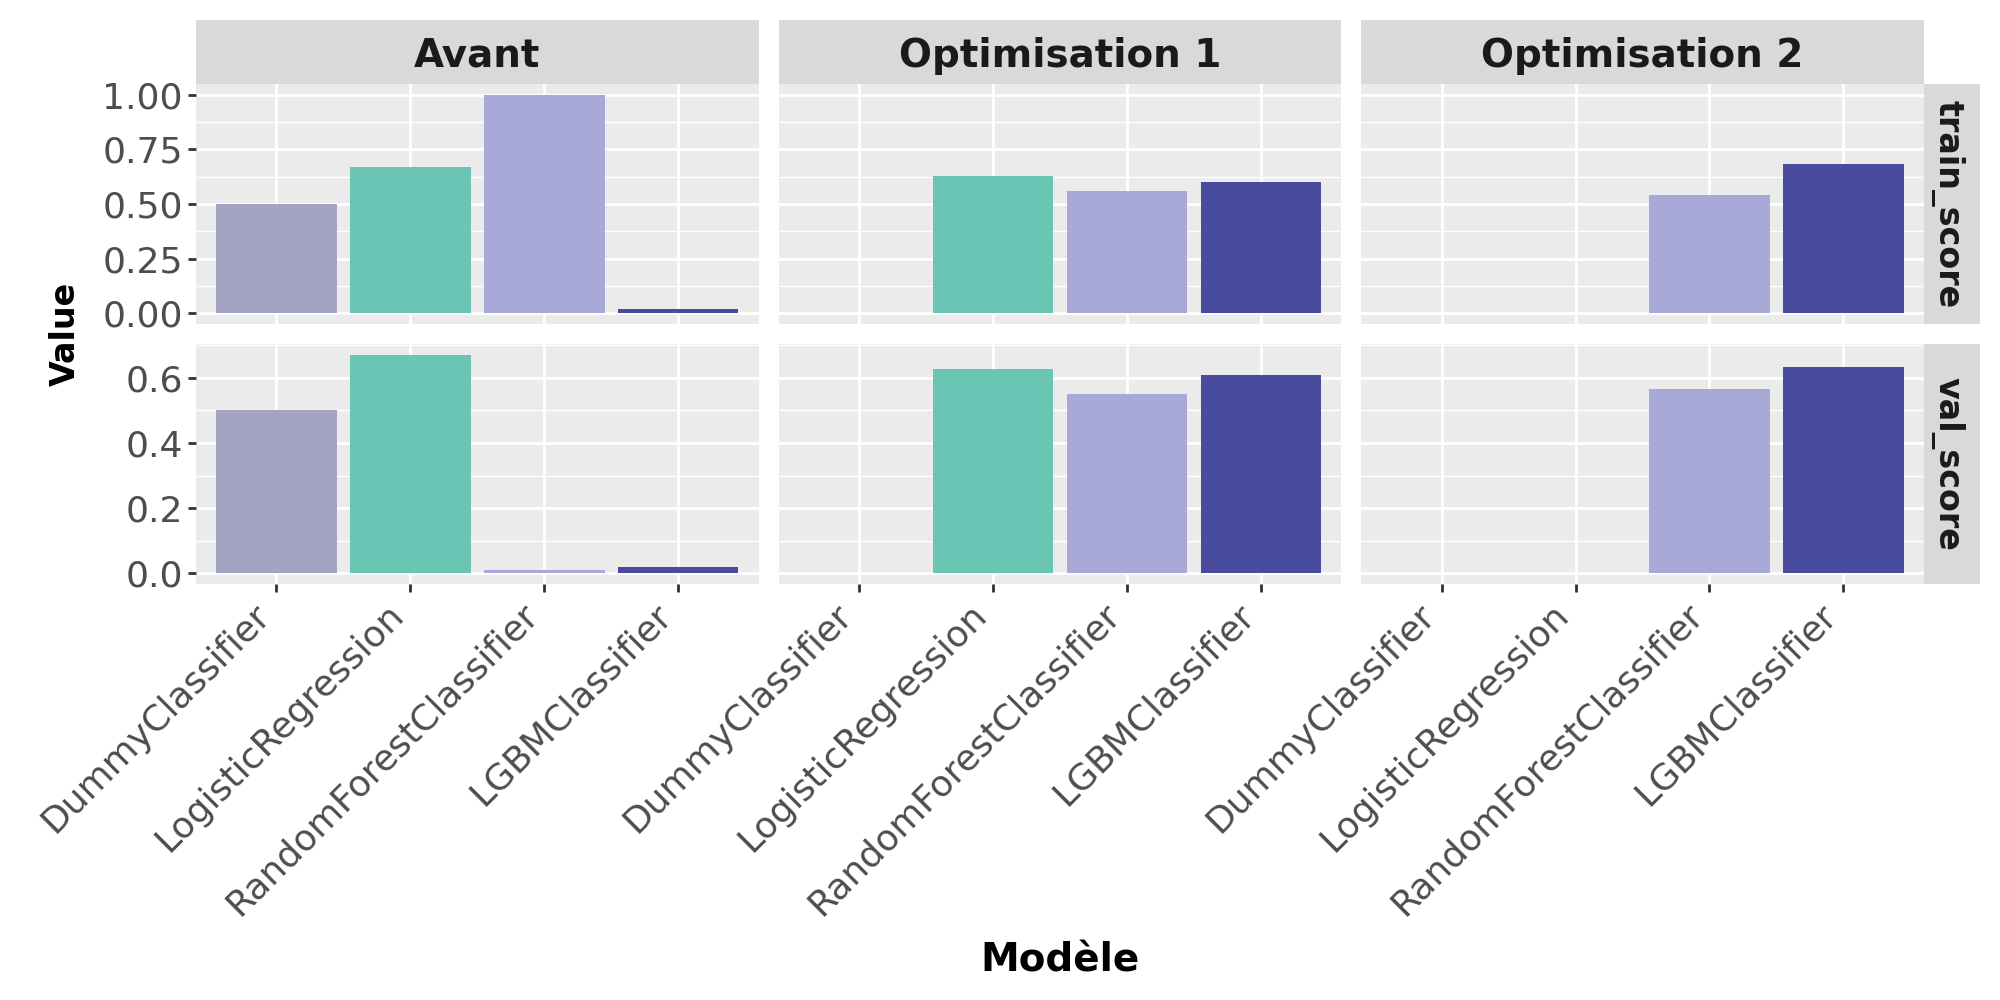

In [43]:
# variable à conserver pour le plot
Feature_opt = ['model', 'score', 'val_score', 'train_score', 'Optimisation']
    
# Filtre de la seconde table d'optimisation
results_opt_df_final_2_recall = results_opt_df_final_2[results_opt_df_final_2['score']=='recall']

# Concat des résultats avant et après la deuxième phase d'optimisation
results_df_final_plot_recall = pd.concat([results_df_final_plot_recall, results_opt_df_final_2_recall[Feature_opt]])

# Définition d'un dictionnaire de correpsondance couleur - modèle
color_mapping = {
        'DummyClassifier': '#a3a3c2',
        'LogisticRegression': '#6ac5b4',
        'RandomForestClassifier': '#a8a9d6',
        'LGBMClassifier': '#494b9c'}

# Appel de la fonction
model_compare_graph(results_df_final_plot_recall, facet_xy='scoring ~ Optimisation', color_mapping=color_mapping, save_name="Comparaison_performances(Recall)_modèles_optimisation2")

Ce second graphique comparant les score de rappel montre qu'à la suite de cette seconde phase d'optimisation, les score de rappel mesurés en validation restent similaire entre les trois modèles ce qui apporte une nouvelle justification sur le choix de selectionner le modèle Light GBM pour la suite.

## Bilan

In [44]:
# Choix du modèle retenu
study = results_2['LGBMClassifier']

In [45]:
# Initialisation d'une liste stockant les paramètres et le score métiers de chaque essaie
data = []

# Pour chaque essai
for trial in study.trials:
    
    # Ajout de la valeur et des paramètres        
    data.append((trial.value, trial.params))

# Conversion de la liste en dataframe
df = pd.DataFrame(data, columns=['value', 'params'])

# Dépliement de la colonne 'params' en colonnes séparées
params_df = pd.json_normalize(df['params'])

# Concaténation pour avoir toutes les colonnes ensemble
df_final = pd.concat([df.drop(columns=['params']), params_df], axis=1)

# Tri de la table par score métier
df_final.sort_values('value', ascending=False).head(5)


,value,smote__sampling_strategy,smote__k_neighbors,clf__n_estimators,clf__max_depth,clf__learning_rate,clf__subsample,clf__colsample_bytree,clf__num_leaves,clf__min_child_samples,clf__reg_alpha,clf__reg_lambda,clf__class_weight
38,0.369861,0.422952,7,31,7,0.157990,0.950626,0.924540,193,10,4.572791,2.561832,balanced
37,0.367438,0.422518,7,30,7,0.155383,0.948699,0.917660,193,12,5.744610,2.513637,balanced
39,0.366991,0.443271,7,30,7,0.155986,0.943911,0.936935,180,9,4.199062,2.559133,balanced
34,0.330407,0.416159,7,39,8,0.151636,0.975770,0.904972,171,13,5.142080,2.387834,balanced
13,0.327911,0.401920,5,50,8,0.185472,0.979611,0.886074,135,14,6.695572,2.383911,balanced


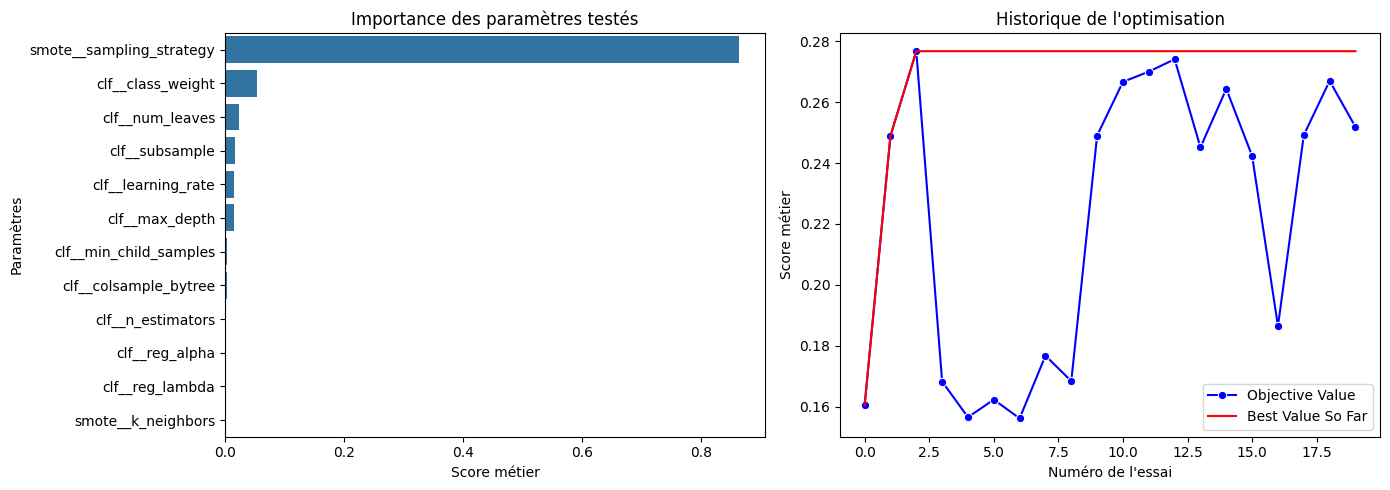

In [46]:
# Appel de la fonction de visualisation des résultats d'optimisation
plot_optuna_summary(results['LGBMClassifier'])

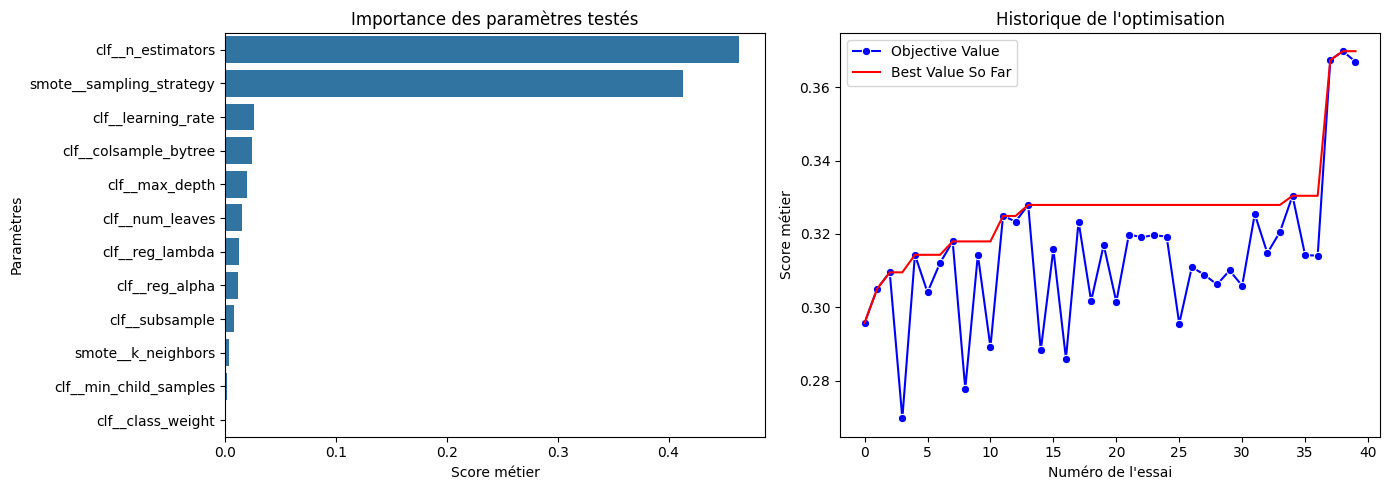

In [47]:
# Appel de la fonction de visualisation des résultats d'optimisation
plot_optuna_summary(results_2['LGBMClassifier'])

Parmi les différents paramètres testés lors des différentes phases d'optimisation du modèle Light GBM, celui qui a eu le plus d'impact sur l'amélioration du score métier est la proportion d'échantillonnage lors de l'étape smote, avec un impact environ dix fois supérieur à celui des autres paramètres. Lors de la première phase d'optimisation, la meilleure combinaison de paramètres a été atteinte dès le troisième essai. Par la suite, la majorité des expérimentations n’ont entraîné que des variations marginales du score. Lors de la seconde phase d'optimisation, le score métier à augmenté régulièrement au cours des différents essais passant d'environs 0.30 au premier essai à plus de 0.36 au dernier essai. Lors de cette seconde phase d'optimisation un autre paramètre à eu un large impact sur l'amélioration du score. Il s'agit du nombre d'arbres.

In [48]:
# Cconstruction de la figure plot slice
fig = plot_slice(study)

# Sauvegarde de la figure pour pouvoir l'afficher de manière permanente
fig.write_html("../Output/slice_plot.html", include_plotlyjs='cdn')

# Affichage de la figure de manière permanente
IFrame("../Output/slice_plot.html", width=900, height=500)

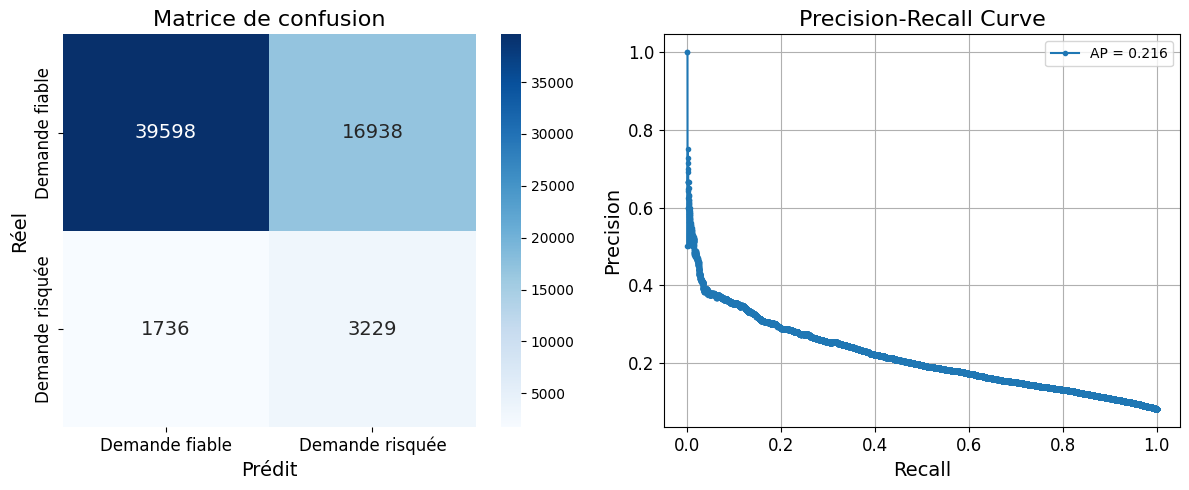

In [49]:
# Selection du pipeline correspondant à la regression logisique
pipe = pipelines_2['LGBMClassifier']

# Prédiction des probabilités sur les données tests
Y_proba_test = pipe.predict_proba(X_test)[:, 1]
Y_prediction_test = (Y_proba_test >= 0.27).astype(int)

# Appel de la fonction de visualisation de la matrice de confusion et de la courbe precision rappel
plot_confmat_and_pr_curve(Y_test,  Y_prediction_test, Y_proba_test, class_names=['Demande fiable', 'Demande risquée'])


La matrice de confusion du modèle Ligth GBM selectionné indique que 65% des demandes de crédits à risque ont été identifiées tout en identifiant près de 70% des demandes de crédits fiables ce qui est en accord avec le score de rappel calculé pendant la phase d'optimisation ce qui permettra à la société de faire des bénéfices. 

# Explicativité du modèle retenu

Mainteant que le modèle final a été selectionné, une prochaine étape importante est de l'expliquer afin de mieux comprendre comment il prend ses décision. Il existe plusieurs manière d'expliquer un modèle.
- **Accéder aux attribut du modèle** : Pour certains modèles, il est possible de récupérer directement l’importance des variables à partir des attributs internes. Par exemple, pour les modèle de type regression logistique cela correspond au coéfficient associés aux différentes variables qui indique l'influence de chaque variable sur les prédictions. Pour les modèles basés sur des arbres il s'agira de la feature importance qui quantifie l'impact global de chaque variable sur les décisions prise par le modèle.
- **Utiliser des librairies spécifiques** : Une librairie particulièrement intéressante correspond à la librairie SHAP qui permet de mesurer la contribution globale de chacune des variable utilisé par un modèle. Cette librairie offre un grand nombre de représentation graphique qui sont simple a interpréter. En plus de l'analyse globale, SHAP permet également d'étudier la contribution locale des variables en analysant comment elles ont influencé les résultat d'une prédiction spécifique.

## Fonctions

Pour cette phase, quatre fonction seront définies
- La première fonction permettra de calculer les valeur SHAP associées aux données d'entrainement et de test.
- La seconde fonction permettra de construire une table de données brute qui soit cohérente avec les étapes de preprocessing effectuées en amont de la classification c'est à dire avec les colonnes générée par l'encodage OneHot
- La troisième fonction permettra de générer un graphique représentant la contribution locale des variable ainsi que plusieurs graphiques représentant la distribution des variables les plus importantes sur lesquelles on pourra retrouver la position de la demande de crédit analysée.
- La quatrième fonction permettra de construire une table de données contenant une variable indiquant pour chaque feature le type de plot (countplot ou boxplot) à constuire pour représenter les distributions.

In [50]:
def get_shap_value(pipeline, X_train, X_test):
    
    """
    Calcule les valeurs SHAP pour un pipeline de classification, sur les ensembles d'entraînement et de test.

    Cette fonction prend un pipeline comprenant :
        - un préprocessing qui transforme les variables d'entrée,
        - une sélection de variables,
        - un classifieur final,
    et retourne les valeurs SHAP correspondant à la classe positive (1) pour les datasets fournis.

    Paramètres:
        - pipeline (sklearn.pipeline): Pipeline scikit-learn contenant les étapes 
          preprocessing, feature_selection et clf.
        - X_train (pandas.DataFrame): Données d'entraînement brutes.
        - X_test (pandas.DataFrame): Données de test brutes.

    Sortie:
        tuple (shap_values_train, shap_values_test)
        - shap_values_train (numpy.ndarray): Valeurs SHAP pour l'ensemble d'entraînement, pour la classe positive.
        - shap_values_test (numpy.ndarray): Valeurs SHAP pour l'ensemble de test, pour la classe positive.
"""
    
    # Extraction des noms des features après preprocessing
    feature_names_after_preprocessing = pipeline.named_steps['preprocessing'].get_feature_names_out(X_train.columns)
    
    # Mask des features sélectionnées
    mask = pipeline.named_steps['feature_selection'].get_support()
    selected_feature_names = feature_names_after_preprocessing[mask]
    
    # Nettoyage des noms de variables
    feature_names_clean = [f.split("__")[-1] for f in selected_feature_names]

    # Prétraitement et selection des variables
    X_train_transformed = pipeline.named_steps['feature_selection'].transform(
        pipeline.named_steps['preprocessing'].transform(X_train))

    X_test_transformed = pipeline.named_steps['feature_selection'].transform(
        pipeline.named_steps['preprocessing'].transform(X_test))

    # Extraction du modèle
    model_final = pipeline.named_steps['clf']

    # Si le model est basé sur des arbres : explainer -> TreeExplainer
    if isinstance(model_final, (lgb.LGBMClassifier, RandomForestClassifier)):
        
        # Initialisation de l'explainer
        explainer = shap.TreeExplainer(model_final, feature_names=feature_names_clean)
        
        # Calcul des valeurs Shap
        shap_values_train = explainer(X_train_transformed)
        shap_values_test = explainer(X_test_transformed)
    
    # Sinon explainer classique
    else:
        
        # Initialisation de l'explainer
        explainer = shap.Explainer(model_final.predict_proba, X_train_transformed, feature_names=feature_names_clean)
        
        # Calcul des valeurs Shap
        shap_values_train = explainer(X_train_transformed)
        shap_values_test = explainer(X_test_transformed)
        
        # Extraction de la position associée à la classe 1
        pos_idx = list(model_final.classes_).index(1)
    
        # Extraction des shap value associées à la classe 1
        shap_values_train = shap_values_train[..., pos_idx]
        shap_values_test  = shap_values_test[..., pos_idx]

    return shap_values_train, shap_values_test, explainer



In [51]:
def raw_data_with_colname_aligned(num_cols_orig, cat_cols_orig, pipeline,
                                  X_train, X_test,
                                  App_train, App_test):
    """
    Retourne des dataframes transformés après préprocessing et sélection de variables,
    tout en alignant les noms des colonnes avec les noms originaux des variables.

    Cette fonction permet de créer des dataframes exploitables pour l'analyse
    ou la visualisation, en conservant :
        - les transformations appliquées par le pipeline (préprocessing + sélection de features),
        - les noms des colonnes correspondant aux features originales,
        - les valeurs brutes pour les variables numériques,
        - l'ID des demandes pour permettre le suivi des lignes.

    Paramètres:
        - num_cols_orig (list of str): Liste des colonnes numériques originales.
        - cat_cols_orig (dict of list of str): Dictionnaire des colonnes catégorielles originales
        - pipeline (sklearn.pipeline): Pipeline scikit-learn contenant les étapes 
          preprocessing et feature_selection.
        - X_train (pandas.DataFrame): Données d'entraînement brutes.
        - X_test (pandas.DataFrame): Données de test brutes.
        - App_train (pandas.DataFrame): Dataframe des applications d'entraînement, contenant l'ID 'SK_ID_CURR'.
        - App_test (pandas.DataFrame): Dataframe des applications de test, contenant l'ID 'SK_ID_CURR'.

    Sortie: 
        tuple (Application_train_2, Application_test_2)
        - Application_train_2 (pandas.DataFrame): Dataframe transformée pour le jeu d'entraînement,
        avec colonnes alignées sur les noms originaux et valeurs numériques brutes.
        - Application_test_2 (pandas.DataFrame): Dataframe transformée pour le jeu de test,
        avec colonnes alignées sur les noms originaux et valeurs numériques brutes.

    """
    # Extraction des noms des features après preprocessing
    feature_names_after_preprocessing = pipeline.named_steps['preprocessing'].get_feature_names_out(X_train.columns)

    # Mask des features sélectionnées
    mask = pipeline.named_steps['feature_selection'].get_support()
    selected_feature_names = feature_names_after_preprocessing[mask]
    
    # Nettoyage des noms de variables
    feature_names_clean = [f.split("__")[-1] for f in selected_feature_names]

    # Prétraitement et selection des variables
    X_train_transformed = pipeline.named_steps['feature_selection'].transform(
        pipeline.named_steps['preprocessing'].transform(X_train))

    X_test_transformed = pipeline.named_steps['feature_selection'].transform(
        pipeline.named_steps['preprocessing'].transform(X_test))

    # Création d'un mapping des noms avant et apres préprocessing
    feature_mapping = {}

    # Pour chaque variable après preprocessing et selection de variables
    for f_trans in feature_names_clean:
        
        # Numérique : match sur la fin du nom
        match_num = next((f for f in num_cols_orig if f_trans.endswith(f)), None)
        if match_num:
            feature_mapping[f_trans] = match_num
            continue

        # Catégoriel : match sur le début pour label et one-hot
        for prefix, cols in cat_cols_orig.items():
            match_cat = next((f for f in cols if f_trans.startswith(f"cat_cols_{prefix}__{f}")), None)
            if match_cat:
                feature_mapping[f_trans] = match_cat
                break

    # Création d'une dataframe basée sur les noms de features après preprocessing et selection
    Application_train_2 = pd.DataFrame(X_train_transformed, columns=feature_names_clean)
    Application_test_2 = pd.DataFrame(X_test_transformed, columns=feature_names_clean)

    # Ajout de l'ID
    Application_train_2['SK_ID_CURR'] = App_train['SK_ID_CURR'].values
    Application_test_2['SK_ID_CURR'] = App_test['SK_ID_CURR'].values

    # Remplacement des valeurs des variables numériques par leurs valeurs brutes
    for f_trans, f_orig in feature_mapping.items():
        if f_orig in num_cols_orig:
            Application_train_2[f_trans] = X_train[f_orig].values
            Application_test_2[f_trans] = X_test[f_orig].values
    
    # Remplacement des valeurs 0/1 par F/M de la variable CODE_GENDER
    if 'CODE_GENDER' in Application_train_2.columns:
        Application_train_2['CODE_GENDER'] = Application_train_2['CODE_GENDER'].map({0: 'F', 1: 'M'})
        Application_test_2['CODE_GENDER'] = Application_test_2['CODE_GENDER'].map({0: 'F', 1: 'M'})

    # Identification des colonnes flag
    flag_cols_train = [col for col in Application_train_2.columns if col.startswith('FLAG')]
    flag_cols_test = [col for col in Application_test_2.columns if col.startswith('FLAG')]
    
    # Remplacement des valeurs 0/1 par non/oui
    Application_train_2[flag_cols_train] = Application_train_2[flag_cols_train].replace({0: 'non', 1: 'oui'})
    Application_test_2[flag_cols_test] = Application_test_2[flag_cols_test].replace({0: 'non', 1: 'oui'})
            
    return Application_train_2, Application_test_2

In [52]:
def explicativite_local(ID, shap_values, App_2, App_1, plot_type, X, pipeline, threshold,
                        n_top=10, text_size=14):
    """
    Visualisation de l'explicabilité locale pour un client donné à l'aide des valeurs SHAP.

    Cette fonction réalise plusieurs actions pour un ID client spécifique :
    1. Affiche un waterfall plot des valeurs SHAP pour visualiser l'impact de chaque variable sur la prédiction.
    2. Construit une Dataframe résumant les features les plus importantes avec :
       - leur valeur SHAP,
       - leur valeur transformée dans la pipeline,
       - leur valeur brute dans le jeu de données,
       - la moyenne globale de la variable.
    3. Génère des graphiques individuels (countplot ou boxplot) pour chaque variable importante,
       en comparant la valeur du client avec la distribution globale.
    4. Affiche la probabilité prédite par le modèle, la classe prédite et la classe réelle du client.

    Paramètres :
        ID (int) : Identifiant unique du client.
        shap_values (np.array) : Tableau des valeurs SHAP calculées sur X.
        App_2 (pd.DataFrame) : Jeu de données brut correspondant aux features attendues par la pipeline.
        App_1 (pd.DataFrame) : Jeu de données contenant la variable cible 'TARGET' pour comparaison.
        plot_type (str) : Type de visualisation principale (non utilisé directement, présent pour compatibilité).
        X (pd.DataFrame) : Jeu de données sur lequel le modèle et SHAP ont été calculés.
        pipeline (sklearn Pipeline) : Pipeline de transformation + modèle entraîné pour prédiction.
        threshold (float) : seuil de classification à utiliser pour prédire la classe positive
        n_top (int, optionnel) : Nombre de features les plus importantes à afficher (par défaut 10).
        text_size (int, optionnel) : Taille de police des titres et axes des graphiques (par défaut 14).

    Sortie :
        data_client (pd.DataFrame) : Dataframe contenant les n_top features les plus importantes pour l'ID avec 
        les valeur SHAP, les valeurs transformées dans la pipeline, les valeurs brutes et la moyenne de la variable
    """
    
    # Waterfall plot
    #--------------------------------------------------------------------------------------------------
    
    # Extraction de la ligne correspondant à l'ID
    pos = App_2.index[App_2['SK_ID_CURR'] == ID][0]
    
    # Affichage du waterfall plot
    shap.plots.waterfall(shap_values[pos], max_display=n_top)
    
    # Construction d'une table stockant les shap value, les valeur transformées et les valeurs réelles
    #--------------------------------------------------------------------------------------------------
    
    # Extraction des valeurs SHAP et des features
    sw = shap_values[pos]
    
    # valeurs brutes pour la demmande de crédit demandée
    value_raw = [App_2.loc[pos, f] if f in App_2.columns else None 
                 for f in sw.feature_names]

    # moyennes globales 
    mean_values = []
    for f in sw.feature_names:
        if f in App_2.columns:
            if pd.api.types.is_numeric_dtype(App_2[f]):
                mean_values.append(App_2[f].mean())
            else:
                # Valeur la plus fréquente
                mean_values.append(App_2[f].mode()[0])
        else:
            mean_values.append(None)
    
    data_client = pd.DataFrame({
        "feature": sw.feature_names,
        "shap_value": sw.values,
        "value_transformed": sw.data,
        "value_raw": value_raw,
        "mean_all" : mean_values
    })
    
    # Tri par importance absolue et sélection des top features
    data_client = data_client.iloc[data_client.shap_value.abs().sort_values(ascending=False).index].head(n_top)
    
    # Construction de graphiques permettant de visualiser le profil du client parmi l'ensemble des clients
    #--------------------------------------------------------------------------------------------------
    
    # Prépation des données
    features = data_client['feature'].tolist()
    n_features = len(features)
    n_cols = 4
    n_rows = math.ceil(n_features / n_cols)
    
    # Initialisation de la figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # Applatissement de l'objet axe
    axes = axes.flatten()
    
    # Pour chaque variable
    for i, f in enumerate(features):
        
        # Extraction de la valeur du client
        val_id = data_client.loc[data_client['feature'] == f, 'value_raw'].values[0]

        # Extraction du type de plot pour la variable f
        plot_choice = plot_types_df.loc[plot_types_df['variable'] == f, 'plot_type'].iloc[0]
        
        # Si la figure associé a la variable est countplot
        if plot_choice=='countplot':
            
            # Construction du countplot
            sns.countplot(x=App_2[f].astype('category'), ax=axes[i],
                          order=sorted(App_2[f].unique()))
            
            # Coloration des barres en fonction de la valeur associée au client
            for patch, x_val in zip(axes[i].patches, sorted(App_2[f].unique())):
                patch.set_facecolor('blue' if x_val == val_id else 'skyblue')
            
            # Ajout de label sur les axes x et y
            axes[i].set_xlabel(f"Count of {f}", fontsize=text_size)
            axes[i].set_ylabel("Count", fontsize=text_size)
        
        # Si la figure associée à la variable est boxplot 
        elif plot_choice=='boxplot':
            
            # Construction d’un boxplot
            sns.boxplot(y=App_2[f], ax=axes[i], color='skyblue')
            
            # Ajout d'une ligne de référence pour l’ID
            axes[i].axhline(val_id, color='blue', linestyle='--', linewidth=4, label=f'ID {ID}')
            
            # Ajout de label
            axes[i].set_ylabel(f, fontsize=text_size)

        # Ajout d'un titre
        axes[i].set_title(f, fontsize=text_size + 2)
        
        # Ajustement de la taille de l'échelle des x et y
        axes[i].tick_params(axis='x', labelsize=text_size - 2)
        axes[i].tick_params(axis='y', labelsize=text_size - 2)

    # Suppression des axes inutilisés
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j])
    
    # Ajustement de l'espace entre les plots
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    
    # Sauvegarde de la figure
    plt.savefig(f'../Output/Explicativité/Distribution_important_features.png', format='png')

    # Affichage du plot
    plt.show()
    
    # Affichage de la proba et classe prédite
    #--------------------------------------------------------------------------------------------------
    
    # Prédiction de la probabilité
    proba = pipeline.predict_proba(X.iloc[[pos]])
    
    # Prédiction de la classe 
    classe = (proba[:, 1] >= threshold).astype(int)
    
    # Label correspondant à la classe prédite
    label = "Demande risquée" if classe == 1 else "Demande fiable"
    
    # Extraction de la classe réelle
    classe_reelle = App_1.iloc[pos]['TARGET']
    
    # Label correspondant à la classe réelle
    label_reel = "Demande risquée" if classe_reelle == 1 else "Demande fiable"

    # Affichage des résultats
    print(f"Classe réelle : {label_reel} \nprobabilités: {proba}  \nClasse prédite: {label} ")
    
    # Retour de la dataframe des features les plus importantes
    return data_client


## Analyses

### All data

In [54]:
# Choix de la pipeline retenu
pipe = pipelines_2['LGBMClassifier']

# Appel de la fonction
shap_values_train, shap_values_test, exp = get_shap_value(pipe, X_train, X_test)

# Sauvegarde des valeur SHAP
joblib.dump(shap_values_train, f"../Output/Shap_value/shap_value_train_{date_str}.joblib")
joblib.dump(shap_values_test, f"../Output/Shap_value/shap_value_test_{date_str}.joblib") 
joblib.dump(exp, f"../Output/Shap_value/exp_{date_str}.joblib") 

['../Output/Shap_value/exp_2025-09-08_22-53-58.joblib']

In [55]:
# Chargement des valeurs SHAP
shap_values_train = joblib.load(f"../Output/Shap_value/shap_value_train_{date_str}.joblib")
shap_values_test = joblib.load(f"../Output/Shap_value/shap_value_test_{date_str}.joblib")

In [56]:
# Colonnes numériques et catégorielles avant preprocessing
num_cols_orig = num_cols_c_approuved + num_cols_c_actifs + num_other_cols
cat_cols_orig = {
    'label': cat_cols_label,
    'one_hot': cat_cols_OneHot
}

# Appel de la fonction pour obtenir la table de données brutes adaptés aux étapes d'encodage des variables catégorielles
App_2 =  raw_data_with_colname_aligned(num_cols_orig, cat_cols_orig,
                                      pipe, X_train, X_test,
                                      App_train_enrichi, App_test_enrichi)

# Extration de la table d'entrainement et de la table test
Application_train_2 = App_2[0]
Application_test_2 = App_2[1]

# Sauvegarde des tables
Application_train_2.to_csv(f"../Output/Shap_value/raw_data_train_with_colname_aligned_{date_str}.csv",  index=False)
Application_test_2.to_csv(f"../Output/Shap_value/raw_data_test_with_colname_aligned_{date_str}.csv",  index=False) 

In [57]:
# Chargement des valeurs SHAP
Application_train_2 = pd.read_csv(f"../Output/Shap_value/raw_data_train_with_colname_aligned_{date_str}.csv")
Application_test_2 = pd.read_csv(f"../Output/Shap_value/raw_data_test_with_colname_aligned_{date_str}.csv")

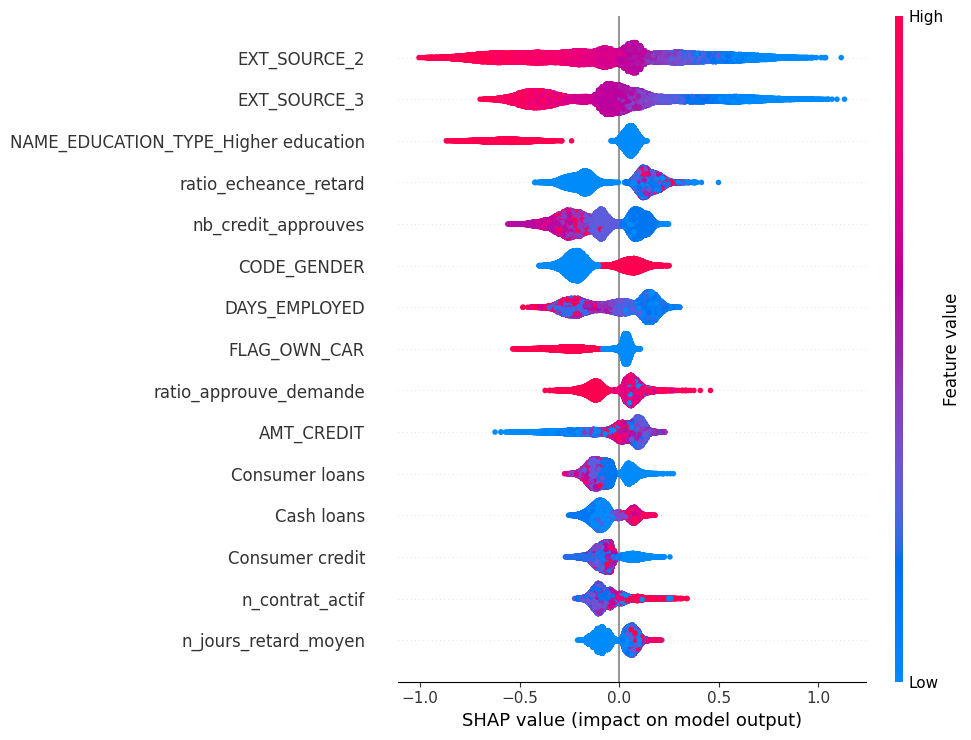

In [59]:
# Génération de nombre aléatoire
rng = np.random.default_rng(42)

# Création de la figure
fig, ax = plt.subplots(figsize=(20, 8))  

# Construction du plot
shap.summary_plot(shap_values_test, show=False, plot_type="dot", max_display=15, rng=rng)

# Extraction de l'axe 
ax = plt.gca()

# Réduction de la taille des labels Y
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

# Ajustement des marges pour que le graphique occupe plus de place
plt.subplots_adjust(left=0.25) 

# Affichage du graphique
plt.show()

L'analyse du summary plot révèlent que les variables qui ont globalement le plus contribué aux prédictions correspondent aux variables EXT_SOURCE_3 et EXT_SOURCE_2 qui sont des scores fournies représantant des indices normalisés entre 0 et 1 où les valeurs proche de 1 sont associées aux profil de client les plus fiable sur le fait de rembourser ou non un crédit. Les résultats du summary plot sont en accord avec cette définition, puisqu'on observe que plus les valeurs de ces variables étaient faible, plus le modèle a eu tendance à prédire des probabilités de défaut de paiment élevées. 

La troisème variable qui a le plus contribué au prédiction correspond à la variable NAME_EDUCATION_TYPE_Higher_education qui prend 1 pour valeur lorsque le demandeur a fait des études supérieures et 0 lorsqu'il n'en a pas fait.  Ici on voit que le modèle a eu tendance a diminuer les probabilités de défaut de paiment lorsque le demandeur avait fait des études supérieures.

Parmis les autres variables ayant le plus contribué aux prédictions on retrouve 
- le ratio d'échéances payées en retard: cet indicateur n'est pas très clair mais on remarque que les ratios plus élevés ont plutôt eu tendance a augmenter la probabilité de paiment.
- le nombre de crédit approuvés : plus le nombre de crédit précédemment accordé était faible, plus la probabilité de défaut de paiment est élevée.
- le genre du demandeur qui prend 1 pour valeur lorsque le demandeur est de sexe masculin et 0 lorsque le demandeur est de sexe féminin.
- le nombre de jours d'emploi du client avant la demande : plus ce nombre est faible plus la probabilité de défaut de paiment est élevée. 
- la possession ou non d'une voiture: la probabilité de défaut de paiment est plus élevée pour les clients qui ne possèdent pas de voiture 
- le nombre de crédits actifs: la probabilité de défaut de paiment est augmentée lorsque le nombre de crédits actifs est élevé

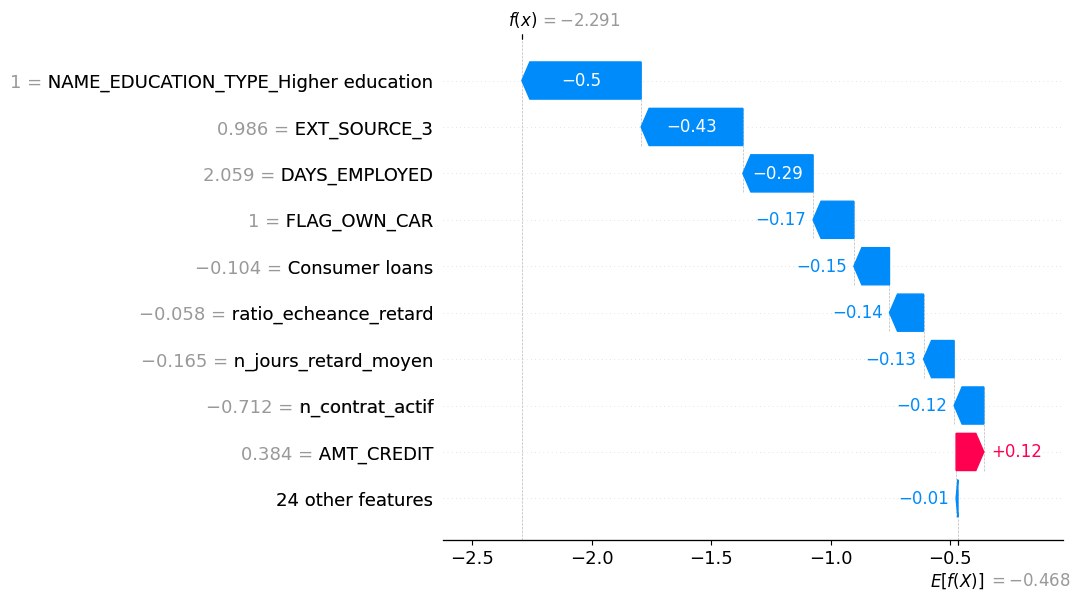

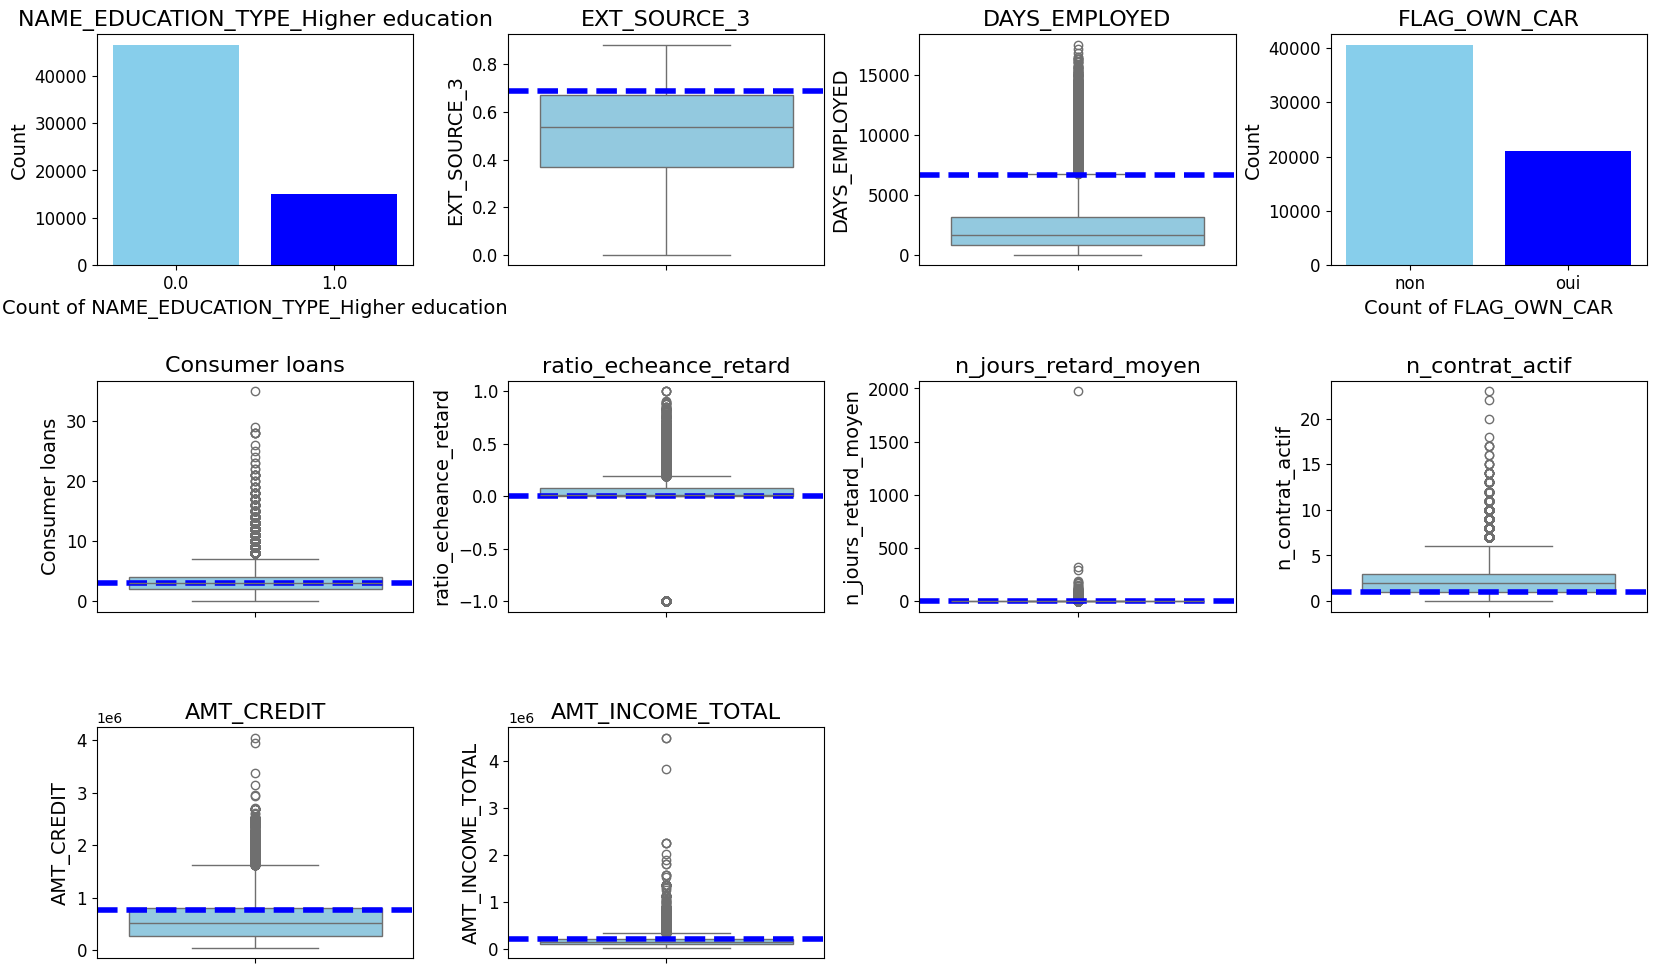

Classe réelle : Demande fiable 
probabilités: [[0.90814159 0.09185841]]  
Classe prédite: Demande fiable 


,feature,shap_value,value_transformed,value_raw,mean_all
32,NAME_EDUCATION_TYPE_Higher education,-0.498619,1.000000,1.0,0.244874
25,EXT_SOURCE_3,-0.425210,0.986053,0.687933,0.51079
20,DAYS_EMPLOYED,-0.293424,2.058834,6655.0,2380.72775
31,FLAG_OWN_CAR,-0.170570,1.000000,oui,non
29,Consumer loans,-0.148927,-0.104075,3.0,3.246153
8,ratio_echeance_retard,-0.142304,-0.057715,0.0,0.0226
7,n_jours_retard_moyen,-0.127793,-0.164557,0.0,0.84967
10,n_contrat_actif,-0.124303,-0.712321,1.0,2.41162
16,AMT_CREDIT,0.116024,0.383636,753840.0,597783.656282
15,AMT_INCOME_TOTAL,-0.112224,0.337198,202500.0,168360.027375


In [60]:
# Appel de la fonction
explicativite_local(372777, shap_values_test, Application_test_2, App_test_enrichi, plot_type=plot_types_df, X=X_test, pipeline=pipe, threshold=0.27)

La demande de crédit analysée a été classée comme étant une demande fiable par le modèle ce qui est cohérent avec la classe réelle de cette demande. La décision du modèle a été influencée par le fait que le client avait fait des études supérieures qui semble stable professionellement, présentant un score EXT_SOURCE_3 élevé, un nombre de contrat actif faible, que c'était une femme qui était propriétaire d'une voiture. D'autres variables ont pu jouer favorablement dans cette décision mais elles ont eu moins d'impact que celles citées ci dessus.

### Echantillon

Dans une dernière étape, l’outil de prédiction sera déployé afin d’être accessible au service client de la société Prêt à Dépenser. Le déploiement sera réalisé à l’aide de FastAPI, qui permettra de créer une interface dont le but sera d'exposer les prédictions du modèle. Les résultats des prédictions pourront ensuite être consultés via un dashboard interactif, capable d’interroger l’API pour récupérer les résultats d’une demande spécifique en temps réel.

Pour mettre en place une version de démonstration de ce dashboard, l'API et le dashboard seront testés sur un échantillon de données. Cela permettra de vérifier la fluidité des échanges avec l'API et d'identifier des améliorations à apporter sur l'interface de présentation des résultats.

Pour garantir à nouveau une représentativité équivalente des classes du jeu de données échantillonné par rapport aux jeu de données de départ, les sous échantillons seront obtenus via la même stratégie de découpage que celle utilisée pour obtenir les jeux de données d'entrainement et de test et une stratégie de stratification sera donc employée.

In [61]:
# Génération d'un échantillon des données d'entrainement en stratifiant sur la variable cible
App_train_enrichi_sample,  _  = train_test_split(
    App_train_enrichi, train_size=1000, stratify=App_train_enrichi['TARGET'], random_state=43
)

# Création des données d'entrainement
X_train_sample = App_train_enrichi_sample[features]

# Génération d'un échantillon des données de test en stratifiant sur la variable cible
App_test_enrichi_sample,  _  = train_test_split(
    App_test_enrichi, train_size=1000, stratify=App_test_enrichi['TARGET'], random_state=43
)

# Création des données de test
X_test_sample = App_test_enrichi_sample[features]


In [62]:
# Choix de la pipeline retenu
pipe = pipelines_2['LGBMClassifier']

# Appel de la fonction
shap_values_train, shap_values_test, exp = get_shap_value(pipe, X_train_sample, X_test_sample)

# Sauvegarde des valeur SHAP
joblib.dump(shap_values_train, f"../Output/Shap_value/shap_value_train_sample_{date_str}.joblib")
joblib.dump(shap_values_test, f"../Output/Shap_value/shap_value_test_sample_{date_str}.joblib") 
joblib.dump(exp, f"../Output/Shap_value/exp_sample_{date_str}.joblib") 

['../Output/Shap_value/exp_sample_2025-09-08_22-53-58.joblib']

In [63]:
# Appel de la fonction pour obtenir la table de données brutes adaptés aux étapes d'encodage des variables catégorielles
App_2 =  raw_data_with_colname_aligned(num_cols_orig, cat_cols_orig,
                                      pipe, X_train_sample, X_test_sample,
                                      App_train_enrichi_sample, App_test_enrichi_sample)

# Extration de la table d'entrainement et de la table test
Application_train_2 = App_2[0]
Application_test_2 = App_2[1]

# Sauvegarde des tables
Application_train_2.to_csv(f"../Output/Shap_value/raw_data_train_with_colname_aligned_sample_{date_str}.csv", index=False)
Application_test_2.to_csv(f"../Output/Shap_value/raw_data_test_with_colname_aligned_sample_{date_str}.csv", index=False) 

# Sauvegarde du modèle pour le déploiement

Pour le déploiement, la pipeline sera sauvegardée après suppression de l’étape SMOTE, qui ne sera pas appliquée lors de l’inférence et dont la présence entraînerait une augmentation inutile du poids de l’objet. Une sauvegarde via une sérialisation grace à joblib permettra de recharger facilement le modèle sur l'API de fastAPI. La pipeline sera aussi enregistrée sur MLFlow afin de conserver une seconde trace de la pipeline dans un outil spécifiquement dédié à la tracabilité des modèles.

In [64]:
# Supression de l'étape smote de la pipeline
pipe.steps = [(name, step) for name, step in pipe.steps if name.lower() != "smote"]

# Nom du modèle
name = pipe.named_steps['clf'].__class__.__name__

# Saugarde de la pipeline
joblib.dump(pipe, f'../Output/Pipelines/pipeline_to_deployed_{name}_{date_str}.joblib')

['../Output/Pipelines/pipeline_to_deployed_LGBMClassifier_2025-09-08_22-53-58.joblib']

In [65]:
# Création de la signature associée au modèle
signature = infer_signature(X_train, Y_train)

# Sauvegarde du modèle avec mlFlow
mlflow.sklearn.save_model(pipe, f'../mlflow/mlflow_model_{name}_{date_str}', signature= signature)

# Conclusions

L'objectif du projet était de développer un outil de scoring capable d'estimer la probabilité qu'un client rembourse son crédit. 

Pour cela, plusieurs tables de données nous ont été fournies: la table de données principale contenait des informations relatives aux demandes de crédits ainsi que plusieurs tables supplémentaires fournissant des informations relatives aux  précédents crédits. Certaines tables étaient spécifiques aux crédits internes à la société tandis que d'autres étaient spécifiques aux crédits externes. Lors de la phase exploratoire, les données ont été divisées en jeux d’entraînement et de test avec une stratification afin de conserver les proportion des classes face au fort déséquilibre de la variable cible. Après un nettoyage approfondi de la table principale, des variables pertinentes ont été extraites et construites à partir des tables supplémentaires, puis agrégées par client.

Pour mettre en place l'outil de scoring, un pipeline a été développé afin d'automatiser l'enchainement des différentes étapes suivantes : prétraitement des données, rééchantillonnage des données et modélisation. Différents modèles ont été explorés et évalué l'aide de scores de performance classiques ainsi que d'un score métier permettant de pénaliser plus fortement les faux négatifs correspondant aux demandes à risque prédites sans risques. Les modèles ont ensuite été optimisé via la même pipeline a laquel une étape de selection de feature a été ajoutée. L'optimisation s'est faite à la fois sur les paramètres du rééchantillonage mais surtout sur les paramètres des différents modèles testés via la mesure du score métier.

Au final, le modèle ayant obtenu le meilleur score métier a été la Régression Logistique mais il est important de noter que l'optimisation n'a finalement pas permis d'améliorer ce score métier qui s'est révélé être stable avant et après l'optimisation. Toutefois en raison du temps d'entrainement particulièrement long de ce modèle, c'est finalement le modèle Ligth GBM qui été selectionné qui a permi d'obtenir des résultats comparables pour un temps d'entrainement bien plus court. Ce modèle retenu a été décrit dans une dernière partie grâce à une analyse d'explicativité globale et locale avec la librairie SHAP. Ainsi les variables qui ont contribué le plus dans les décisions de ce modèle sont des variables qui évaluaient déjà le risque de défaut de paiment.

Dans une prochaine étape, le modèle sera mis à disposition du service client de la société Prêt à Dépenser via le développement d’une API, qui pourra être interrogée par un dashboard. Celui ci permettra aux conseillers non seulement d'utiliser cet outil d'aide à la décision en visualisant les prédictions mais aussi d'accéder à des informations complémentaires pertinentes relatives aux demandes de crédit ce qui facilitera sans doute l'évaluation du risque de chaque demande et une prise de décision éclairée.